In [63]:
import numpy as np
import pandas as pd
import calc_rates
import fit_model
import rpy2
%load_ext rpy2.ipython
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.transforms
import matplotlib.lines
import seaborn
import scipy.integrate
import scipy.optimize
import scipy.stats
import importlib
import multiprocessing
import itertools
import logging
import pickle
import collections
import color_scheme
# import numpy.random
import os


plt.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = (
    r"\usepackage{amsmath}" 
    + r"\usepackage{siunitx}" 
    + r"\usepackage{lmodern}" 
    + r"\input{" + f"{os.path.abspath('../data/00_abbrevs.tex')}" + r"}"
    + r"\sisetup{detect-all}"
    + r"\usepackage{sansmathfonts}"
)

np.random.seed(0)


logging.basicConfig(level=logging.WARNING)

fig_path = "../figs/"
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["font.size"] = 14
# plt.rcParams["font.family"] = "sans-serif"



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


set global constants

In [64]:
Y_XG = 0.627
Y_PG = 0.652
Y_MG = 73.753

R = 8.314  # gas constant
kB = 1.38e-23  # boltzmann constant
h = 6.63e-34  # planck constant

density_glycerol = 1.261

no_points = 7  # using model fits where sampling times are used
alpha = 0.2  # level of significance used in the model framework

In [65]:
data_dir = "../data/"


# the 2 function are necessary to load defaultdict from pickeled objects
def dict_list():
    return collections.defaultdict(list)


def dict_dict():
    return collections.defaultdict(dict)


with open(f"{data_dir}base_feed.pickle", "rb") as f:
    base_feed = pickle.load(f)

with open(f"{data_dir}spline_dfs.pickle", "rb") as f:
    spline_dfs = pickle.load(f)

with open(f"{data_dir}spline_functions.pickle", "rb") as f:
    f_spline = pickle.load(f)

with open(f"{data_dir}odes.pickle", "rb") as f:
    odes = pickle.load(f)

with open(f"{data_dir}dfs_fit.pickle", "rb") as f:
    dfs_fit = pickle.load(f)

with open(f"{data_dir}dfs_CV.pickle", "rb") as f:
    dfs_CV = pickle.load(f)

with open(f"{data_dir}dfs_CV_plot.pickle", "rb") as f:
    dfs_CV_plot = pickle.load(f)

with open(f"{data_dir}odes_CV.pickle", "rb") as f:
    odes_CV = pickle.load(f)


with open("../data/dfs_fit.pickle", "rb") as f:
    dfs_vars = pickle.load(f)

with open("../data/data_df.pickle", "rb") as f:
    data_df = pickle.load(f)

with open("../data/c_feed.pickle", "rb") as f:
    c_feed = pickle.load(f)

In [66]:
target_temperatures = {
    "DoE1_R1": 35,
    "DoE1_R2": 31,
    "DoE1_R3": 27,
    "DoE1_R4": 31,
    "DoE2_R1": 27,
    "DoE2_R2": 31,
    "DoE2_R3": 35,
    "DoE2_R4": 31,
    "DoE3_R1": 31,
    "DoE3_R2": 31,
    "DoE3_R3": 25.3,
    "DoE3_R4": 36.7,
}

In [67]:
data_df.V.max()

2.515375

### Import data, calculate absolute masses and correct for sampling

As long as there is no substrate accumulation in the medium the base feed can be estimated by the growth rate. For model fitting the experimental base feed is used, for optimization this estimation is required.

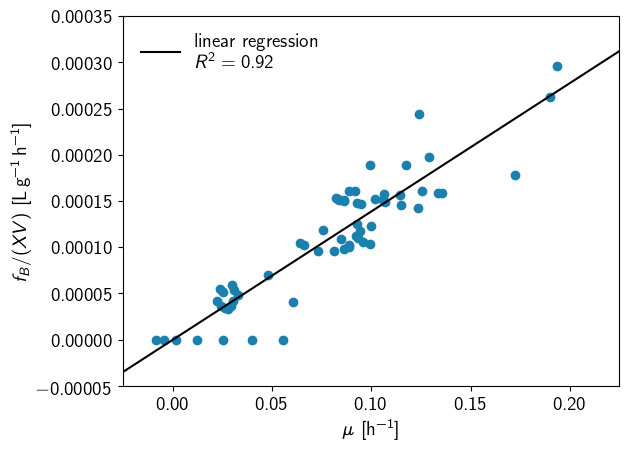

In [68]:
def f_base(process, t):
    return f_spline[process].f(t) * (1 - f_spline[process].c_feed(t) / c_feed[process])


df = data_df[
    data_df.process.isin(
        [
            "DoE1_R2",
            "DoE1_R4",
            "DoE2_R2",
            "DoE2_R4",
            "DoE3_R1",
            "DoE1_R3",
            "DoE2_R3",
            "DoE3_R3",
            "DoE3_R4",
        ]
    )
]

fs_base = [
    f_base(process, t) / (X * V)
    for t, X, V, process in zip(df.t, df.X, df.V, df.process)
]
mus = [f_spline[process].mu(t) for t, process in zip(df.t, df.process)]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(mus, fs_base)
fig, ax = plt.subplots(1, 1)
ax.scatter(mus, fs_base, c=color_scheme.general[0])
x = np.linspace(-0.05, 0.3, 100)
ax.plot(
    x, slope * x + intercept, c="k", label=f"linear regression\n$R^2 = {r_value:.2f}$"
)
ax.set_xlabel(r"$\mu$ [\unit{\per\hour}]")
ax.set_ylabel(r"$f_B / (X V)$ [\unit{\liter\per\gram\per\hour}]")
ax.set_xlim(-0.025, 0.225)
ax.set_ylim(-0.00005, 0.00035)
ax.legend(loc="upper left", frameon=False)
plt.savefig(f"{fig_path}f_base_fit.png", bbox_inches="tight")
plt.show()

In [69]:
slope, intercept, r_value, p_value, std_err

(0.0013879678463941398,
 -1.110819007471564e-07,
 0.9154207288106241,
 2.157415004376013e-25,
 7.878564568901556e-05)

In [70]:
f_base = fit_model.FBase(slope, intercept)

with open("../data/f_base.pickle", "wb") as f:
    pickle.dump(f_base, f)

## Spline fits

In [71]:
process_names = [
    "DoE1_R2",
    "DoE1_R4",
    "DoE2_R2",
    "DoE2_R4",
    "DoE3_R1",
    "DoE1_R3",
    "DoE2_R3",
    "DoE3_R3",
    "DoE3_R4",
    "DoE3_R2",
    "DoE2_R1",
    "DoE1_R1",
]

center_points = [
    "DoE1_R2",
    "DoE1_R4",
    "DoE2_R2",
    "DoE2_R4",
]


data_df_all = pd.read_csv(f"{data_dir}sampling_points.csv", index_col=0)
df_Vf = pd.read_csv(f"{data_dir}volume_flow_rates.csv", index_col=0)
df_T = pd.read_csv(f"{data_dir}temperatures.csv", index_col=0)
# c_feed = pd.read_csv(f"{data_dir}c_feed.csv", index_col="process").c_feed.to_dict()

# for k, v in c_feed.items():
#     density = 1 + v / 1000 * (1 - 1 / density_glycerol)
#     c_feed[k] = v / density

label_groups = [
    [
        "DoE1_R2",
        "DoE1_R4",
        "DoE2_R2",
        "DoE2_R4",
    ],
    [
        "DoE3_R1",
        "DoE1_R3",
        "DoE2_R3",
        "DoE3_R3",
        "DoE3_R4",
    ],
    [
        "DoE3_R2",
        "DoE2_R1",
        "DoE1_R1",
    ],
]


# short_labels_groups = [
#     [
#         "$\qG = 0.3$",
#         "$\qG = 0.3$",
#         "$\qG = 0.3$",
#         "$\qG = 0.3$",
#     ],
#     [
#         "$\qG = 0.017$",
#         "$\qG = 0.1$",
#         "$\qG = 0.1$",
#         "$\qG = 0.3$",
#         "$\qG = 0.3$",
#     ],
#     [
#         "$\qG = 0.5$",
#         "$\qG = 0.5$",
#         "$\qG = 0.583$",
#     ],
# ]

short_labels_groups = [
    [
        "$\mu_f = 0.11$",
        "$\mu_f = 0.11$",
        "$\mu_f = 0.11$",
        "$\mu_f = 0.12$",
    ],
    [
        "$\mu_f = 0.01$",
        "$\mu_f = 0.04$",
        "$\mu_f = 0.04$",
        "$\mu_f = 0.12$",
        "$\mu_f = 0.12$",
    ],
    [
        "$\mu_f = 0.20$",
        "$\mu_f = 0.20$",
        "$\mu_f = 0.24$",
    ],
]

styles_group = ["-", "--", "dashdot", ":", (0, (5, 1, 1, 1, 1, 1))] * 3
colors_group = color_scheme.processes
markers_group = ["o", "P", "X", "v", "1"] * 3

_, plot_df_all, _ = calc_rates.calc_rates_df(
    data_df_all,
    df_Vf,
    c_feed,
    Y_XG,
    Y_PG,
    k=3,
    s=10,
    df_points=np.linspace(0, 12.5, 100),
    df_T=df_T,
    # s_dense=1e-2,
)

In A2 and B2 we see that 1 datapoint does not follow the trend. We assume a measurment error here and delete this data point.In addition w adapt the spline fitting parameters $k$ and $s$ to get smooth splines for all processes.

In [72]:
if 40 in data_df.index:
    data_df.drop(40, inplace=True)

df_measurement_points, df_dense, f = calc_rates.calc_rates_df(
    data_df, df_Vf, c_feed, Y_XG, Y_PG, k=3, s=10, df_T=df_T
)

# _, df_dense13, _ = calc_rates.calc_rates_df(
#     data_df, df_Vf, c_feed, Y_XG, Y_PG, k=3, s=10, df_points=np.linspace(0, 12, 13), df_T=df_T
# )

# _, df_dense49, _ = calc_rates.calc_rates_df(
#     data_df, df_Vf, c_feed, Y_XG, Y_PG, k=3, s=10, df_points=np.linspace(0, 12, 49), df_T=df_T
# )

# df_dense11 = df_dense13[(df_dense13.t > 1) & (df_dense13.t < 11)]
# df_dense23 = df_dense[(df_dense.t > 1) & (df_dense.t < 11)]
# df_dense47 = df_dense49[(df_dense49.t > 1) & (df_dense49.t < 11)]
# df_dense5 = df_measurement_points[
#     (df_measurement_points.t > 1) & (df_measurement_points.t < 11)
# ]

_, plot_df, _ = calc_rates.calc_rates_df(
    data_df,
    df_Vf,
    c_feed,
    Y_XG,
    Y_PG,
    k=3,
    s=10,
    df_points=np.linspace(0, 12.5, 100),
    df_T=df_T,
)
# create_plots.plot_spline_fit(
#     label_groups,
#     short_labels_groups,
#     colors_group,
#     styles_group,
#     markers_group,
#     plot_df,
#     data_df,
#     file=f"{fig_path}spline_fit.png",
# )

In [73]:
matplotlib.colors.to_hex([0, 0, 0, 0])

'#000000'

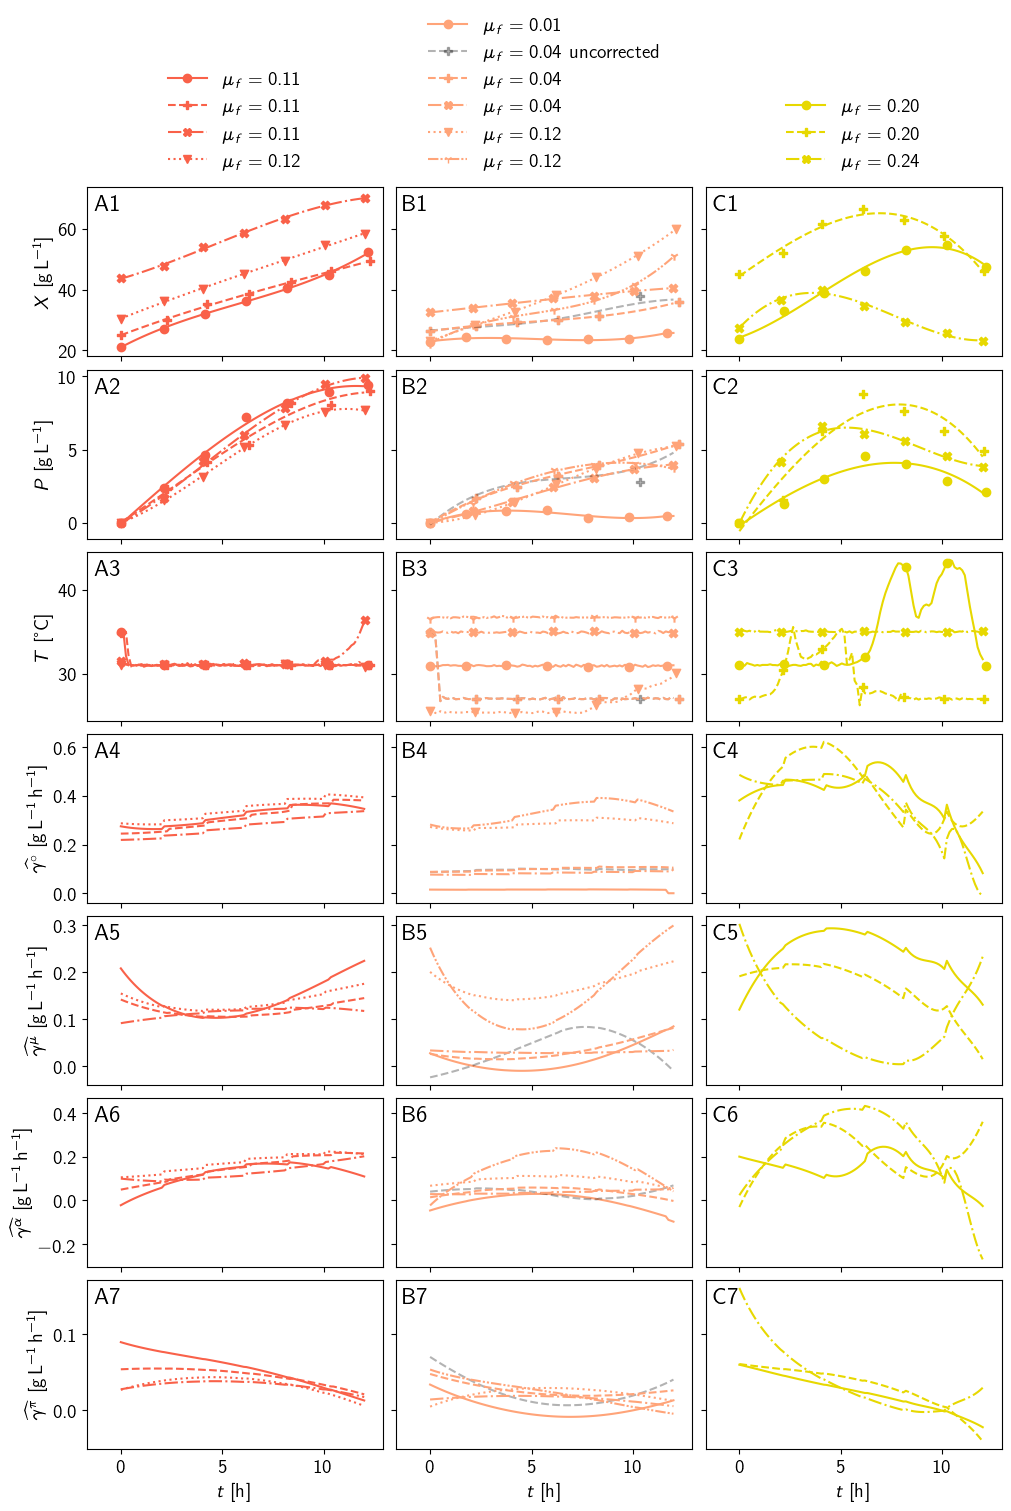

In [74]:
def plot_spline_fit(
    label_groups,
    short_labels_groups,
    colors_group,
    styles_group,
    markers_group,
    spline_df,
    data_df,
    file=None,
    corrected_processes=["DoE1_R3"],
    uncorrected_df=plot_df_all,
    data_df_all=data_df_all,
):
    def plot_process(df, df_estimates, c, m, label, axs):
        df_estimates = df_estimates[df_estimates.t <= 12]
        axs[0, i].scatter(df.t, df.X, c=c, marker=m)
        axs[0, i].plot(df_estimates.t, df_estimates.X, ls=ls, c=c)
        axs[1, i].scatter(df.t, df.P, c=c, marker=m)
        axs[1, i].plot(df_estimates.t, df_estimates.P, ls=ls, c=c)
        axs[2, i].scatter(df.t, df["T"] - 273.15, c=c, marker=m)
        axs[2, i].plot(df_estimates.t, df_estimates["T"] - 273.15, ls=ls, c=c)
        axs[0, i].plot([-1], [0], c=c, ls=ls, marker=m, label=label)
        axs[3, i].plot(df_estimates.t, df_estimates.g, ls=ls, c=c)
        axs[4, i].plot(df_estimates.t, df_estimates.g_mu, ls=ls, c=c)
        axs[5, i].plot(df_estimates.t, df_estimates.gm, ls=ls, c=c)
        axs[6, i].plot(df_estimates.t, df_estimates.gP, ls=ls, c=c)

    no_groups = len(label_groups)
    fig, axs = plt.subplots(
        7, no_groups, figsize=(10, 15), layout="constrained", sharex=True, sharey="row"
    )
    for i, (labels, short_labels, c) in enumerate(
        zip(label_groups, short_labels_groups, colors_group)
    ):
        for label, short_label, ls, m in zip(
            labels, short_labels, styles_group, markers_group
        ):
            df = data_df_all[data_df_all.process == label]
            if label in corrected_processes:
                df_uncorrected = uncorrected_df[uncorrected_df.process == label]
                plot_process(
                    df,
                    df_uncorrected,
                    matplotlib.colors.to_hex([0, 0, 0, 0.3], keep_alpha=True),
                    m,
                    f"{short_label} uncorrected",
                    axs,
                )

            df = data_df[data_df.process == label]
            df_estimates = spline_df[spline_df.process == label]
            plot_process(df, df_estimates, c, m, short_label, axs)

    # [ax.set_ylim(20, 75) for ax in axs[0, :]]
    # [ax.set_ylim(0, 6) for ax in axs[1, :]]
    [ax.set_ylim(18, None) for ax in axs[0, :]]

    axs[0, 0].set_ylabel(r"$X$ [\si{\gram\per\liter}]")
    axs[1, 0].set_ylabel(r"$P$ [\si{\gram\per\liter}]")
    axs[2, 0].set_ylabel(r"$T$ [\si{\celsius}]")
    axs[3, 0].set_ylabel(r"$\widehat{\g}$ [\si{\gram\per\liter\per\hour}]")
    axs[4, 0].set_ylabel(r"$\widehat{\gmu}$ [\si{\gram\per\liter\per\hour}]")
    axs[5, 0].set_ylabel(r"$\widehat{\gm}$ [\si{\gram\per\liter\per\hour}]")
    axs[6, 0].set_ylabel(r"$\widehat{\gP}$ [\si{\gram\per\liter\per\hour}]")
    [ax.set_xlabel(r"$t$ [\si{\hour}]") for ax in axs[6, :]]

    [
        ax.legend(loc="lower center", bbox_to_anchor=(0.5, 1), ncol=1, frameon=False)
        for ax in axs[0, :]
    ]

    # fig.tight_layout()

    for name, ax in zip(
        [
            f"{col}{row}"
            for row in range(1, 8)
            for col in ["A", "B", "C"]
        ],
        [axs[i, j] for i in range(7) for j in range(no_groups)],
    ):
        trans = matplotlib.transforms.ScaledTranslation(
            5 / 72, -5 / 72, fig.dpi_scale_trans
        )
        ax.text(
            0.0,
            1.0,
            name,
            transform=ax.transAxes + trans,
            fontsize="large",
            verticalalignment="top",
            fontfamily="sans",
            bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
        )

    if file is not None:
        plt.savefig(file)

    plt.show()


plot_spline_fit(
    label_groups,
    short_labels_groups,
    colors_group,
    styles_group,
    markers_group,
    plot_df,
    data_df,
    file=f"{fig_path}spline_fit_detailed.png",
)

In [75]:
# Calculate the variation in the experimental dataset. We use the centerpoint,
# correct for different X0 and V0 and calculate the expected error (measurment and biological variation)
# within a run and between runs.

dfs = list()
for i, process in enumerate(center_points):
    df = data_df[data_df.process == process].copy()
    df["X_corr"] = df.X * df.V / (df.X.iloc[0] * df.V.iloc[0])
    df["P_corr"] = df.P * df.V / (df.X.iloc[0] * df.V.iloc[0])
    df = df[df.t > 0]
    dfs.append(df)

X_mean = np.sum([dfs[i].X_corr.values for i in range(4)], axis=0) / 4
P_mean = np.sum([dfs[i].P_corr.values for i in range(4)], axis=0) / 4
P_mean

systematic_errors_X = list()
random_errors_X = list()
systematic_errors_P = list()
random_errors_P = list()
for i, df in enumerate(dfs):
    rel_error_X = (df.X_corr - X_mean) / X_mean
    systematic_errors_X.append(rel_error_X.mean())
    random_errors_X.append(rel_error_X.var())
    rel_error_P = (df.P_corr - P_mean) / P_mean
    systematic_errors_P.append(rel_error_P.mean())
    random_errors_P.append(rel_error_P.var())

print(
    f"X rel. variation between runs: {np.std(systematic_errors_X)}\n"
    + f"X rel. variation within run: {(np.mean(random_errors_X))**(0.5)}\n"
    + f"P rel. variation between runs: {np.std(systematic_errors_P)}\n"
    + f"P rel. variation within run: {(np.mean(random_errors_P))**0.5}"
)

X rel. variation between runs: 0.07532839668208981
X rel. variation within run: 0.02960704645983619
P rel. variation between runs: 0.2982643342441833
P rel. variation within run: 0.08140395115351952


## Dependence of pruduction and maintenence on substrate uptake

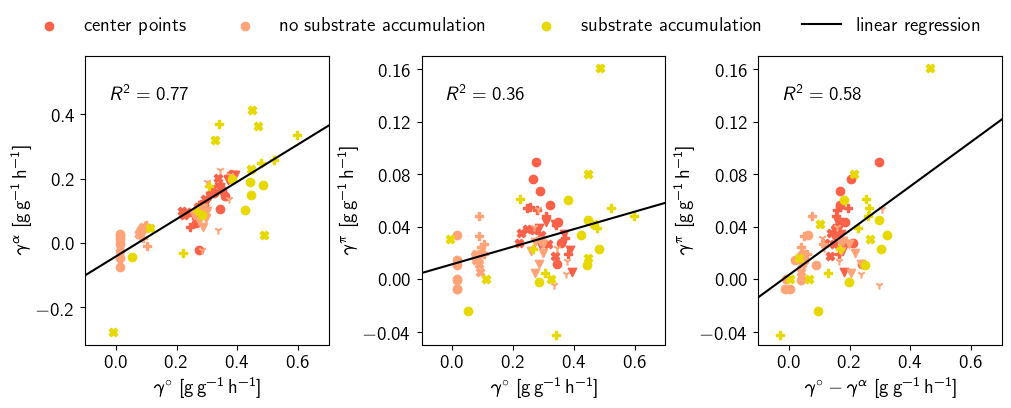

In [76]:
def plot_qm_qP_qG(spline_df, markers, colors, file=None):
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3.5), layout="constrained")
    labels = spline_df.process.unique()
    df = spline_df
    for label, c, m in zip(labels, colors, markers):
        df_process = df[df.process == label]
        if label == "DoE1_R2":
            label = "center points"
        elif label == "DoE3_R1":
            label = "no substrate accumulation"
        elif label == "DoE3_R2":
            label = "substrate accumulation"
        else:
            label = None
        ax0.scatter(df_process.g, df_process.gm, c=c, marker=m, label=label)
        ax1.scatter(df_process.g, df_process.gP, c=c, marker=m)
        ax2.scatter(df_process.g - df_process.gm, df_process.gP, c=c, marker=m)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df.g, df.gm)
    ax0.plot(
        [-0.1, 1],
        [intercept - 0.1 * slope, intercept + slope],
        c="k",
        label="linear regression",
    )
    ax0.set_xlim(-0.1, 0.7)
    ax0.text(0.1, 0.85, f"$R^2 = {r_value:.2f}$", transform=ax0.transAxes)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df.g, df.gP)
    ax1.plot([-0.1, 1], [intercept - 0.1 * slope, intercept + slope], c="k")
    ax1.set_xlim(-0.1, 0.7)
    ax1.text(0.1, 0.85, f"$R^2 = {r_value:.2f}$", transform=ax1.transAxes)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        df.g - df.gm, df.gP
    )
    ax2.plot([-0.1, 1], [intercept - 0.1 * slope, intercept + slope], c="k")
    ax2.set_xlim(-0.1, 0.7)
    ax2.text(0.1, 0.85, f"$R^2 = {r_value:.2f}$", transform=ax2.transAxes)

    ax0.set_xlabel(r"$\g$ [\unit{\gram\per\gram\per\hour}]")
    ax1.set_xlabel(r"$\g$ [\unit{\gram\per\gram\per\hour}]")
    ax2.set_xlabel(r"$\g - \gm$ [\unit{\gram\per\gram\per\hour}]")

    ax0.set_ylabel(r"$\gm$ [\unit{\gram\per\gram\per\hour}]")
    ax1.set_ylabel(r"$\gP$ [\unit{\gram\per\gram\per\hour}]")
    ax2.set_ylabel(r"$\gP$ [\unit{\gram\per\gram\per\hour}]")

    [ax.set_ylim(-0.05, 0.17) for ax in [ax1, ax2]]
    [ax.set_yticks(np.linspace(-0.04, 0.16, 6)) for ax in [ax1, ax2]]

    fig.legend(loc="lower center", ncol=4, bbox_to_anchor=(0.5, 1), frameon=False)

    if file is not None:
        fig.savefig(file, bbox_inches="tight")


markers = ["o", "P", "X", "v"] + ["o", "P", "X", "v", "1"] + ["o", "P", "X"]
colors = (
    [color_scheme.processes[0]] * 4
    + [color_scheme.processes[1]] * 5
    + [color_scheme.processes[2]] * 3
)
styles = (
    ["-", "--", "dashdot", ":"]
    + ["-", "--", "dashdot", ":", (0, (5, 1, 1, 1, 1, 1))]
    + ["-", "--", "dashdot"]
)

plot_qm_qP_qG(df_measurement_points, markers, colors, file=f"{fig_path}qm_qP_qG")

## Determine the significant parameter for this model

We use linear models to find the significant parameter and later fit our nonlinear model for those parameters

In [77]:
# alpha (significance leves) is defined below
# the alpha with the highest cross validation R squared
# is used

f_ode = odes[alpha][no_points].f
ode = odes[alpha][no_points]
f_g = odes[alpha][no_points].f_g
f_gm = odes[alpha][no_points].f_gm
f_gP = odes[alpha][no_points].f_gP

dfs_var = dfs_vars[alpha][no_points]
spline_df = spline_dfs[no_points]

In [78]:
# R squared and adjusted R squared is calculated for the 3 fitted rates
# for the selected value as well as for the full model


df = spline_df[spline_df.G > 1e-1]


def calc_R_squared_adj(df, df_var, var="g"):
    """return R^2 and adjusted R^2 for a given variable"""
    var_tot = sum((df[var] - df[var].mean()) ** 2)
    no_values = len(df)
    no_vars = sum([len(x) for x in df_var.parameters])
    R_squared_adj = 1 - (df_var.variance.iloc[0] / (no_values - no_vars)) / (
        var_tot / (no_values - 1)
    )
    return (
        1 - df_var.variance.iloc[0] / var_tot,
        R_squared_adj,
        # df_var.variance.iloc[0],
        # var_tot,
    )


res = list()
res.append(
    [
        *calc_R_squared_adj(df, dfs_var["g"], "g"),
        *calc_R_squared_adj(df, dfs_var["g_full"], "g"),
    ]
)
res.append(
    [
        *calc_R_squared_adj(spline_df, dfs_var["gm"], "gm"),
        *calc_R_squared_adj(spline_df, dfs_var["gm_full"], "gm"),
    ]
)
res.append(
    [
        *calc_R_squared_adj(spline_df, dfs_var["gP"], "gP"),
        *calc_R_squared_adj(spline_df, dfs_var["gP_full"], "gP"),
    ]
)
pd.DataFrame(
    res,
    columns=[
        "R squared",
        "adj R squared",
        "R squared full model",
        "adj R squared full model",
    ],
    index=["g", "gm", "gP"],
)

,R squared,adj R squared,R squared full model,adj R squared full model
g,0.543123,0.516248,0.578265,0.240876
gm,0.675284,0.667166,0.739358,0.711181
gP,0.696856,0.677171,0.732875,0.703996


In [79]:
# calculate increased variance if another term is removed

dfs_var["g"]["add_error [%]"] = (
    dfs_var["g"].explained_variance / dfs_var["g"].variance.iloc[0] * 100
)
dfs_var["g"]

,variable,parameters,p_value,variance,explained_variance,add_error [%]
0,const,[0.4861523434818964],0.000000,0.225043,0.000000,0.000000
1,Gi,[88.72632024260699],0.052577,0.492568,0.267525,118.877213


In [80]:
dfs_var["gm"]["add_error [%]"] = (
    dfs_var["gm"].explained_variance / dfs_var["gm"].variance.iloc[0] * 100
)
dfs_var["gm"]
# parameter definition is changed for the final manuscript, (inverse values are used)

,variable,parameters,p_value,variance,explained_variance,add_error [%]
0,const,[2.4389401145229037e-05],0.000000,0.313808,0.000000,0.000000
1,g,[9679.439167593344],0.000033,0.757876,0.444068,141.509371
2,P_X,[9.329208195510446],0.081991,0.428478,0.114670,36.541369


In [81]:
dfs_var["gP"]["add_error [%]"] = (
    dfs_var["gP"].explained_variance / dfs_var["gP"].variance.iloc[0] * 100
)
dfs_var["gP"]

,variable,parameters,p_value,variance,explained_variance,add_error [%]
0,const,[8.844462196138477e-09],0.000000,0.017785,0.000000,0.000000
1,g_gm,[0.6160224695821981],0.000002,0.051162,0.033377,187.667293
2,n,[1.4634398953503478],0.035036,0.026660,0.008875,49.901853
3,T,"[51939.795341646466, 4788293.1307881195, 309.6...",0.071930,0.024596,0.006811,38.298635


In [82]:
df = dfs_CV[0.2][7].copy()
df["PX"] = df.P / df.X
df["PX_est"] = df.P_est / df.X_est
df["PX_est_CV"] = df.P_est_CV / df.X_est_CV

In [83]:
# calculation of fitting quality for X, P, P/X

def calc_vars(df, var, var_est, dof=12):
    """calculates R^2 and adjusten R^2 for state variables X, P or P/X"""
    total_var = np.sum((df[var] - df[var].mean()) ** 2)
    var = np.sum((df[var] - df[var_est]) ** 2)
    R_squared = 1 - var / total_var
    R_squared_adj = 1 - var / (len(df) - dof) / (total_var / (len(df) - 1))
    return R_squared, R_squared_adj


res = list()
res.append([*calc_vars(df, "X", "X_est"), *calc_vars(df, "X", "X_est_CV")])
res.append([*calc_vars(df, "P", "P_est"), *calc_vars(df, "P", "P_est_CV")])
res.append([*calc_vars(df, "PX", "PX_est"), *calc_vars(df, "PX", "PX_est_CV")])
pd.DataFrame(
    res, index=["X", "P", "PX"], columns=["R2", "R2_adj", "CV_R2", "CV_R2_adj"]
)

,R2,R2_adj,CV_R2,CV_R2_adj
X,0.834037,0.808325,0.633571,0.576800
P,0.821836,0.794233,0.752390,0.714028
PX,0.734308,0.693145,0.558945,0.490613


In [84]:
# calculation of fitting quality for the rates g, gm, gP


def get_R2(df, alpha, no_points, odes, odes_CV):
    gs = list()
    gms = list()
    gPs = list()
    g_errors = list()
    g_errors_CV = list()
    gm_errors = list()
    gm_errors_CV = list()
    gP_errors = list()
    gP_errors_CV = list()
    for i, r in df.iterrows():
        gm_est = odes[alpha][no_points].f_gm(r.g, r.G, r.n, r.P, r.X, r["T"])
        gm_est_CV = odes_CV[alpha][no_points][r.process].f_gm(
            r.g, r.G, r.n, r.P, r.X, r["T"]
        )
        gms.append(r.gm)
        gm_errors.append(r.gm - gm_est)
        gm_errors_CV.append(r.gm - gm_est_CV)
        gP_est = odes[alpha][no_points].f_gP(r.g, r.gm, r.G, r.n, r.P, r.X, r["T"])
        gP_est_CV = odes_CV[alpha][no_points][r.process].f_gP(
            r.g, r.gm, r.G, r.n, r.P, r.X, r["T"]
        )
        gPs.append(r.gP)
        gP_errors.append(r.gP - gP_est)
        gP_errors_CV.append(r.gP - gP_est_CV)

        if r.G > 0.1:
            g_est = odes[alpha][no_points].f_g(r.G, r.n, r.P, r.X, r["T"])
            g_est_CV = odes_CV[alpha][no_points][r.process].f_g(
                r.G, r.n, r.P, r.X, r["T"]
            )
            # print(r.g - 0.25, g_est - 0.25, g_est_CV - 0.25)
            gs.append(r.g)
            g_errors.append(r.g - g_est)
            g_errors_CV.append(r.g - g_est_CV)

    gs = np.array(gs)
    gms = np.array(gms)
    gPs = np.array(gPs)
    g_errors = np.array(g_errors)
    g_errors_CV = np.array(g_errors_CV)
    gm_errors = np.array(gm_errors)
    gm_errors_CV = np.array(gm_errors_CV)
    gP_errors = np.array(gP_errors)
    gP_errors_CV = np.array(gP_errors_CV)

    # print(np.mean(g))

    R2_g = 1 - np.sum((g_errors) ** 2) / np.sum((gs - np.mean(gs)) ** 2)
    R2_g_CV = 1 - np.sum(g_errors_CV**2) / np.sum((gs - np.mean(gs)) ** 2)
    # print(np.mean(abs(g_errors)), np.mean(abs(g_errors_CV)), np.mean(abs(gs - np.mean(gs))))
    R2_gm = 1 - np.sum(gm_errors**2) / np.sum((gms - np.mean(gms)) ** 2)
    R2_gm_CV = 1 - np.sum(gm_errors_CV**2) / np.sum((gms - np.mean(gms)) ** 2)
    R2_gP = 1 - np.sum(gP_errors**2) / np.sum((gPs - np.mean(gPs)) ** 2)
    R2_gP_CV = 1 - np.sum(gP_errors_CV**2) / np.sum((gPs - np.mean(gPs)) ** 2)

    return R2_g, R2_g_CV, R2_gm, R2_gm_CV, R2_gP, R2_gP_CV


pd.DataFrame(
    np.reshape(get_R2(spline_dfs[no_points], alpha, no_points, odes, odes_CV), (3, 2)),
    index=["g", "gm", "gP"],
    columns=["R_squared", "R_squared_CV"],
)

,R_squared,R_squared_CV
g,0.542395,0.439199
gm,0.675284,0.520835
gP,0.696856,0.398739


## Cross Validation

As reference we calculate the cross validation for a model without any inhibition.

In [85]:
df_CV = dfs_CV[alpha][no_points]
alphas = list(dfs_CV.keys())
no_data_points = list(dfs_CV[alphas[0]].keys())

In [86]:
def clac_R2(values, est, CV_est):
    R2 = 1 - np.sum((values - est) ** 2) / np.sum((values - np.mean(values)) ** 2)
    R2_CV = 1 - np.sum((values - CV_est) ** 2) / np.sum((values - np.mean(values)) ** 2)
    return R2, R2_CV


def plot_R2_XP(dfs_CV, no_data_points, ax_P, ax_X, ax_PX, colors):
    R2s_X = list()
    R2s_X_CV = list()
    R2s_P = list()
    R2s_P_CV = list()
    R2s_PX = list()
    R2s_PX_CV = list()
    alphas = dfs_CV.keys()
    for alpha in alphas:
        df = dfs_CV[alpha][no_data_points]
        R2, R2_CV = clac_R2(df.X, df.X_est, df.X_est_CV)
        R2s_X.append(R2)
        R2s_X_CV.append(R2_CV)
        R2, R2_CV = clac_R2(df.P, df.P_est, df.P_est_CV)
        R2s_P.append(R2)
        R2s_P_CV.append(R2_CV)
        R2, R2_CV = clac_R2(df.P / df.X, df.P_est / df.X_est, df.P_est_CV / df.X_est_CV)
        R2s_PX.append(R2)
        R2s_PX_CV.append(R2_CV)

    ax_P.plot(alphas, R2s_P, color=colors[0])
    ax_P.plot(alphas, R2s_P_CV, color=colors[1])
    ax_X.plot(alphas, R2s_X, color=colors[0])
    ax_X.plot(alphas, R2s_X_CV, color=colors[1])
    ax_PX.plot(alphas, R2s_PX, color=colors[0])
    ax_PX.plot(alphas, R2s_PX_CV, color=colors[1])

In [87]:
def get_g_errors(df_dense, alpha, no_points, odes, odes_CV):
    df = df_dense[df_dense.t > 0]
    gs = list()
    gs_est = list()
    gs_est_CV = list()
    gms = list()
    gms_est = list()
    gms_est_CV = list()
    gPs = list()
    gPs_est = list()
    gPs_est_CV = list()
    for i, r in df.iterrows():
        gm_est = odes[alpha][no_points].f_gm(r.g, r.G, r.n, r.P, r.X, r["T"])
        gm_est_CV = odes_CV[alpha][no_points][r.process].f_gm(
            r.g, r.G, r.n, r.P, r.X, r["T"]
        )
        gms.append(r.gm)
        gms_est.append(gm_est)
        gms_est_CV.append(gm_est_CV)
        gP_est = odes[alpha][no_points].f_gP(r.g, r.gm, r.G, r.n, r.P, r.X, r["T"])
        gP_est_CV = odes_CV[alpha][no_points][r.process].f_gP(
            r.g, r.gm, r.G, r.n, r.P, r.X, r["T"]
        )
        gPs.append(r.gP)
        gPs_est.append(gP_est)
        gPs_est_CV.append(gP_est_CV)

        if r.G > 0.1:
            g_est = odes[alpha][no_points].f_g(r.G, r.n, r.P, r.X, r["T"])
            g_est_CV = odes_CV[alpha][no_points][r.process].f_g(
                r.G, r.n, r.P, r.X, r["T"]
            )
            gs.append(r.g)
            gs_est.append(g_est)
            gs_est_CV.append(g_est_CV)

    gs = np.array(gs)
    gs_est = np.array(gs_est)
    gs_est_CV = np.array(gs_est_CV)
    gms = np.array(gms)
    gms_est = np.array(gms_est)
    gms_est_CV = np.array(gms_est_CV)
    gPs = np.array(gPs)
    gPs_est = np.array(gPs_est)
    gPs_est_CV = np.array(gPs_est_CV)

    g_R2 = 1 - np.sum((gs - gs_est) ** 2) / np.sum((gs - gs.mean()) ** 2)
    g_R2_CV = 1 - np.sum((gs - gs_est_CV) ** 2) / np.sum((gs - gs.mean()) ** 2)
    gm_R2 = 1 - np.sum((gms - gms_est) ** 2) / np.sum((gms - gms.mean()) ** 2)
    gm_R2_CV = 1 - np.sum((gms - gms_est_CV) ** 2) / np.sum((gms - gms.mean()) ** 2)
    gP_R2 = 1 - np.sum((gPs - gPs_est) ** 2) / np.sum((gPs - gPs.mean()) ** 2)
    gP_R2_CV = 1 - np.sum((gPs - gPs_est_CV) ** 2) / np.sum((gPs - gPs.mean()) ** 2)

    return (
        g_R2,
        g_R2_CV,
        gm_R2,
        gm_R2_CV,
        gP_R2,
        gP_R2_CV,
    )


g_R2s = collections.defaultdict(dict)
g_R2s_CV = collections.defaultdict(dict)
gm_R2s = collections.defaultdict(dict)
gm_R2s_CV = collections.defaultdict(dict)
gP_R2s = collections.defaultdict(dict)
gP_R2s_CV = collections.defaultdict(dict)

df_dense = spline_dfs[no_points]
for alpha in alphas:
    (
        g_R2,
        g_R2_CV,
        gm_R2,
        gm_R2_CV,
        gP_R2,
        gP_R2_CV,
    ) = get_g_errors(df_dense, alpha, no_points, odes, odes_CV)
    g_R2s[alpha][no_points] = g_R2
    g_R2s_CV[alpha][no_points] = g_R2_CV
    gm_R2s[alpha][no_points] = gm_R2
    gm_R2s_CV[alpha][no_points] = gm_R2_CV
    gP_R2s[alpha][no_points] = gP_R2
    gP_R2s_CV[alpha][no_points] = gP_R2_CV

In [88]:
def plot_g_error(no_points, ax_g, ax_gm, ax_gP, colors, labels=[None, None]):
    ax_g.plot(
        alphas,
        [g_R2s[alpha][no_points] for alpha in alphas],
        label=labels[0],
        c=colors[0],
    )
    ax_g.plot(
        alphas,
        [g_R2s_CV[alpha][no_points] for alpha in alphas],
        label=labels[1],
        c=colors[1],
    )
    ax_gm.plot(alphas, [gm_R2s[alpha][no_points] for alpha in alphas], c=colors[0])
    ax_gm.plot(alphas, [gm_R2s_CV[alpha][no_points] for alpha in alphas], c=colors[1])
    ax_gP.plot(alphas, [gP_R2s[alpha][no_points] for alpha in alphas], c=colors[0])
    ax_gP.plot(alphas, [gP_R2s_CV[alpha][no_points] for alpha in alphas], c=colors[1])

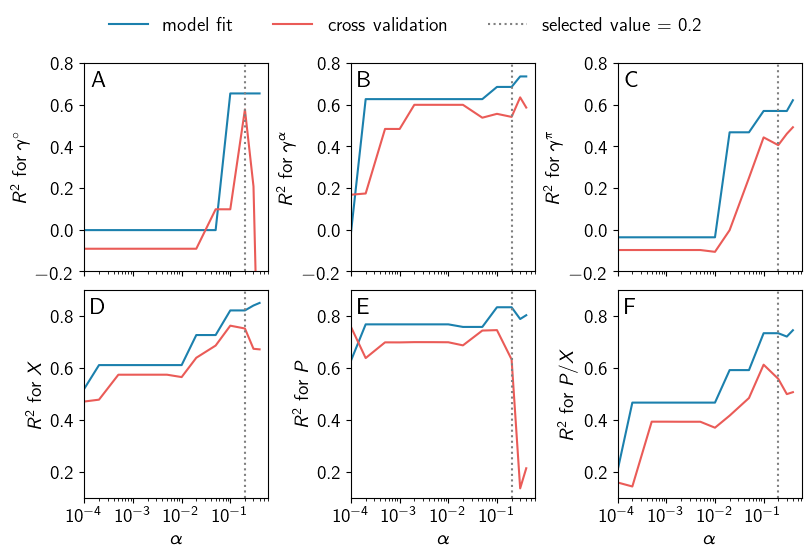

In [89]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(8, 5),
    layout="constrained",
    sharex=True,
    # sharey="row"
)

plot_g_error(
    7,
    ax0,
    ax1,
    ax2,
    labels=["model fit", "cross validation"],
    colors=color_scheme.general,
)
[ax.set_xscale("log") for ax in (ax0, ax1, ax2, ax3, ax4, ax5)]

[ax.set_xlabel(r"$\alpha$") for ax in (ax3, ax4, ax5)]
ax0.set_ylabel(r"$R^2$ for $\g$")
ax1.set_ylabel(r"$R^2$ for $\gm$")
ax2.set_ylabel(r"$R^2$ for $\gP$")

plot_R2_XP(dfs_CV, 7, ax3, ax4, ax5, colors=color_scheme.general)
# plot_CV_error_X(7, ax3, colors=color_scheme.general)
# plot_CV_error_P(7, ax4, colors=color_scheme.general)
# plot_CV_error(7, ax5, colors=color_scheme.general)
ax3.set_ylabel(r"$R^2$ for $X$")
ax4.set_ylabel(r"$R^2$ for $P$")
ax5.set_ylabel(r"$R^2$ for $P/X$")

[ax.set_ylim(-0.2, 0.8) for ax in (ax0, ax1, ax2)]
[ax.set_ylim(0.1, 0.9) for ax in (ax3, ax4, ax5)]
# [ax.set_xticks(alphas) for ax in (ax0, ax1, ax2)]
[ax.set_xlim(1e-4, None) for ax in (ax0, ax1, ax2)]
ax0.vlines(
    0.2,
    ax0.get_ylim()[0],
    ax0.get_ylim()[1],
    color="grey",
    ls=":",
    label="selected value = 0.2",
)
[
    ax.vlines(0.2, ax.get_ylim()[0], ax.get_ylim()[1], color="grey", ls=":")
    for ax in (ax1, ax2, ax3, ax4, ax5)
]
fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5, 1), frameon=False)


for name, ax in zip(["A", "B", "C", "D", "E", "F"], [ax0, ax1, ax2, ax3, ax4, ax5]):
    trans = matplotlib.transforms.ScaledTranslation(
        5 / 72, -5 / 72, fig.dpi_scale_trans
    )
    ax.text(
        0,
        1.0,
        name,
        transform=ax.transAxes + trans,
        fontsize="large",
        verticalalignment="top",
        fontfamily="sans",
        bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
    )

fig.savefig(f"{fig_path}alpha_selection", bbox_inches="tight")

plt.show()

In [90]:
t = np.linspace(0, 11, 25)
mu_feed = dict()
for process in process_names:
    res_fit = scipy.stats.linregress(
        t,
        np.log(
            f_spline[process].f(t)
            * f_spline[process].c_feed(t)
            / f_spline[process].sampling_factor(t)
        ),
    )
    # print(f"{process}: f0 * c_feed = {np.exp(res_fit.intercept)}, mu = {res_fit.slope}")
    mu_feed[process] = res_fit.slope

## Plot model fits and CV fits

In [91]:
def plot_fits_XPG(
    data_df,
    model_df,
    f_spline,
    X_column,
    P_column,
    G_column,
    mu_feed,
    label_groups,
    styles_group,
    colors_group,
    markers_group,
    file=None,
):
    fig, axs = plt.subplots(
        5, 3, figsize=(12, 12), sharey="row", sharex=True, layout="constrained"
    )
    for i, (l, c) in enumerate(zip(label_groups, colors_group)):
        plot_handels = list()
        plot_labels = list()
        for label, ls, m in zip(l, styles_group, markers_group):
            df = model_df[model_df.process == label]
            data = data_df[data_df.process == label]
            axs[1, i].plot(df.t, df[X_column], c=c, ls=ls)
            axs[2, i].plot(df.t, df[P_column], c=c, ls=ls)
            axs[3, i].plot(df.t, df[G_column], c=c, ls=ls)
            # axs[3, i].plot(df.t, df["T"], c=c, ls=ls)
            ts = np.linspace(data.t.min(), data.t.max(), 100)
            axs[4, i].plot(ts, f_spline[label].T(ts) - 273.15, c=c, ls=ls)
            axs[0, i].plot(df.t, df[P_column] / df[X_column], c=c, ls=ls)
            # axs[5, i].plot(
            #     df.t,
            #     [
            #         f_spline[p].f(t) / X * f_spline[p].c_feed(t)
            #         for t, p, X in zip(df.t, df.process, df[X_column])
            #     ],
            #     c=c,
            #     ls=ls,
            # )

            axs[1, i].scatter(data.t, data.X, c=c, marker=m)
            axs[2, i].scatter(data.t, data.P, c=c, marker=m)
            axs[3, i].scatter(data.t, data.G, c=c, marker=m)
            axs[4, i].scatter(data.t, data["T"] - 273.15, c=c, marker=m)
            axs[0, i].scatter(data.t, data.P / data.X, c=c, marker=m)

            plot_handels.append(matplotlib.lines.Line2D([], [], marker=m, c=c, ls=ls))
            plot_labels.append(r"$\mu_{f} = " + f"{mu_feed[label]:.2f}$")
        axs[0, i].legend(
            plot_handels,
            plot_labels,
            loc="upper center",
            ncol=2,
            handlelength=3,
            bbox_to_anchor=(0.5, 1.5),
            frameon=False,
        )

        # print(df)

    axs[1, 0].set_ylabel(r"$X$ [\si{\gram\per\liter}]")
    axs[2, 0].set_ylabel(r"$P$ [\si{\gram\per\liter}]")
    axs[3, 0].set_ylabel(r"$G$ [\si{\gram\per\liter}]")
    axs[4, 0].set_ylabel(r"$T$ [\si{\celsius}]")
    axs[0, 0].set_ylabel(r"$P/X$ [\si{\gram\per\gram}]")
    # axs[5, 0].set_ylabel("Feed per biomass [g G (g X)$^{-1}$]")

    [ax.set_xlabel("t [h]") for ax in axs[-1, :]]

    # [ax.set_ylim(20, 99) for ax in axs[0, :]]
    # [ax.set_ylim(0, 0.6) for ax in axs[5, :]]

    [ax.set_xticklabels([]) for ax in axs[0:-1, :].reshape(-1)]
    # [ax.set_yticklabels([]) for ax in axs[:, 1:].reshape(-1)]

    for name, ax in zip(
        [
            "A1",
            "B1",
            "C1",
            "A2",
            "B2",
            "C2",
            "A3",
            "B3",
            "C3",
            "A4",
            "B4",
            "C4",
            "A5",
            "B5",
            "C5",
        ],
        axs.reshape(-1),
    ):
        trans = matplotlib.transforms.ScaledTranslation(
            5 / 72, -5 / 72, fig.dpi_scale_trans
        )
        ax.text(
            0.0,
            1.0,
            name,
            transform=ax.transAxes + trans,
            fontsize="large",
            verticalalignment="top",
            fontfamily="sans",
            bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
        )

    if file is not None:
        plt.savefig(file, bbox_inches="tight")

    plt.show()

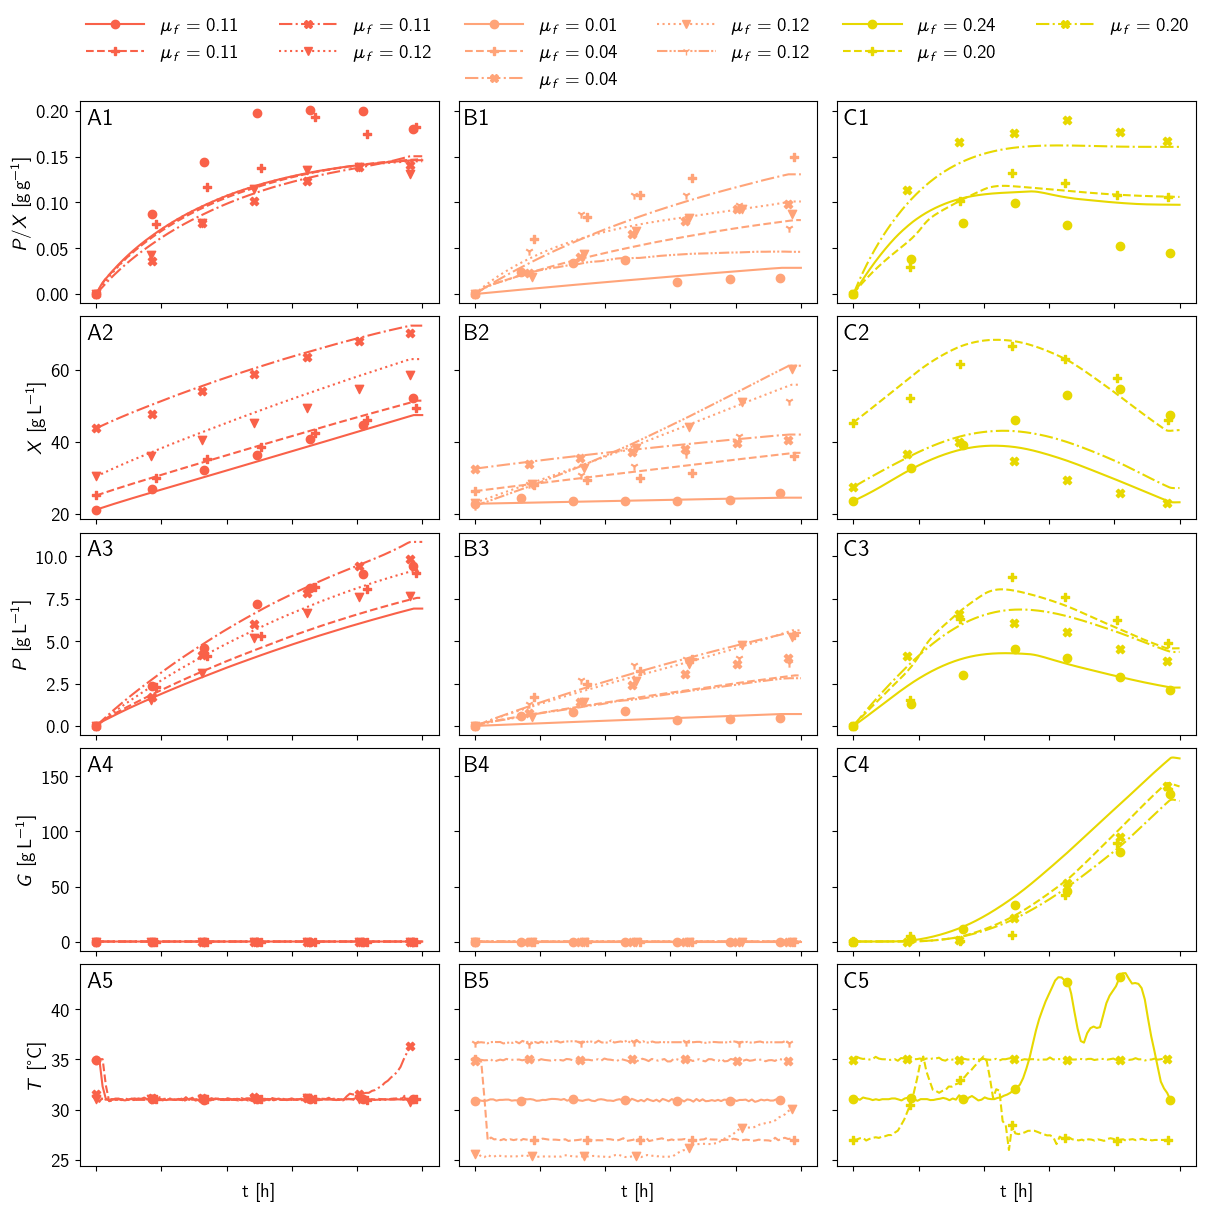

In [92]:
plot_fits_XPG(
    data_df,
    dfs_CV_plot[alpha][no_points],
    f_spline,
    "X_est",
    "P_est",
    "G_est",
    mu_feed,
    # short_labels_groups,
    label_groups,
    styles_group,
    colors_group,
    markers_group,
    file=f"{fig_path}model_fit.png",
)

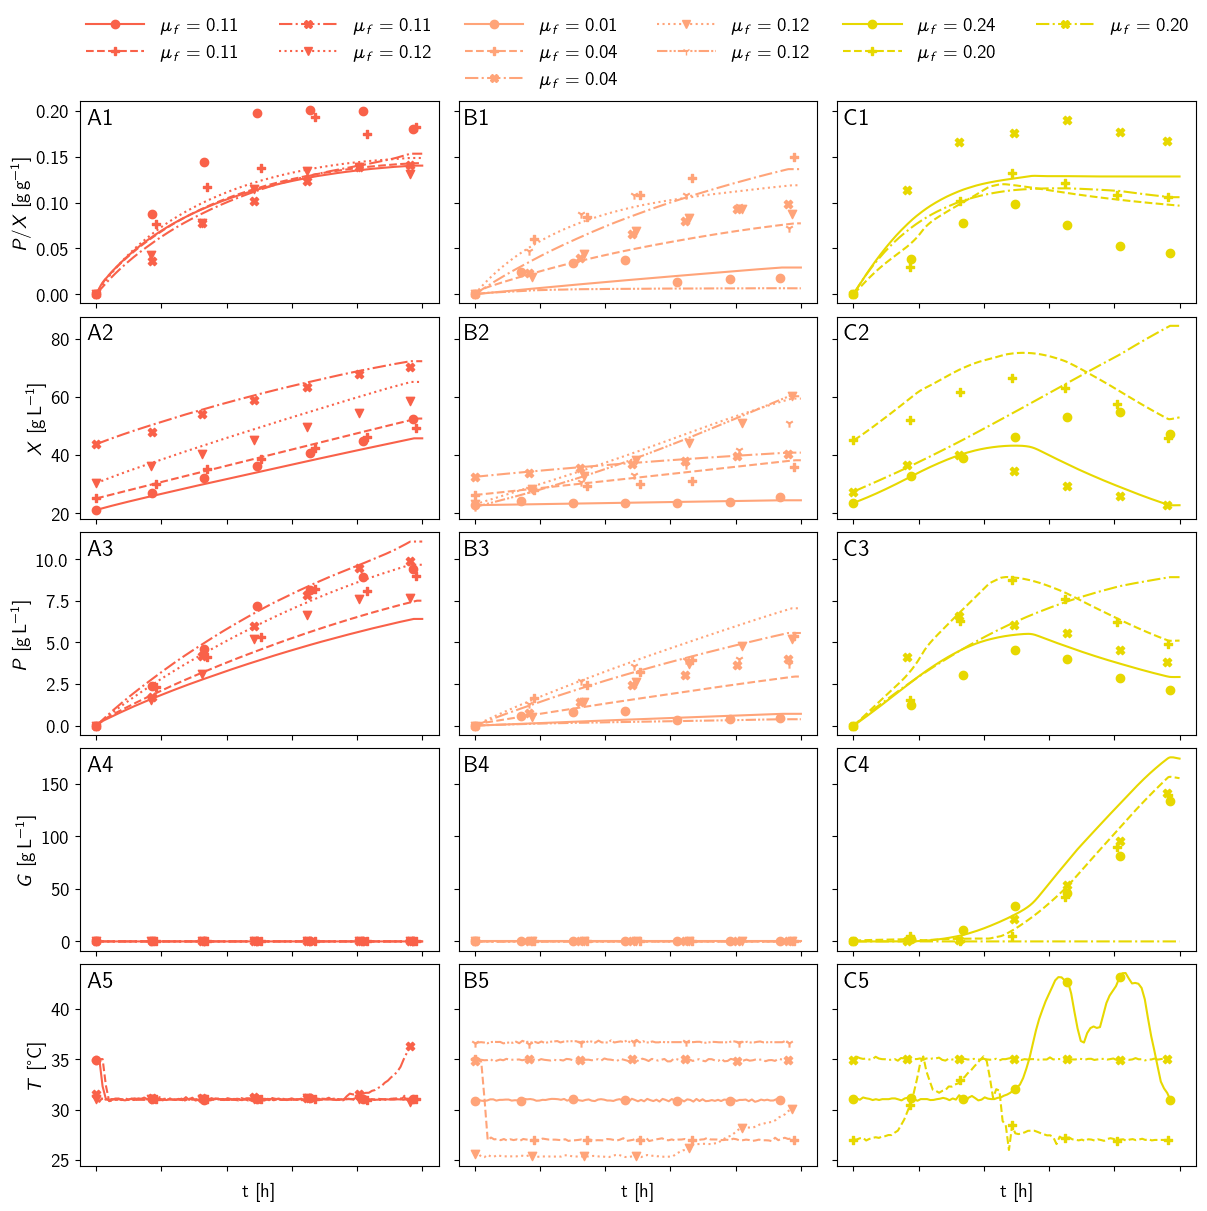

In [93]:
plot_fits_XPG(
    data_df,
    dfs_CV_plot[alpha][no_points],
    f_spline,
    "X_est_CV",
    "P_est_CV",
    "G_est_CV",
    mu_feed,
    label_groups,
    styles_group,
    colors_group,
    markers_group,
    file=f"{fig_path}cross_val.png",
)

## Plot fitting errors for $g$ for $q_m$, and $q_P$

In [94]:
groups = list()
for i, r in df_measurement_points.iterrows():
    if r.process in label_groups[0]:
        groups.append("center point")
    elif r.process in label_groups[1]:
        groups.append("no substrate accumulation")
    else:
        groups.append("substrate accumulation")

df_measurement_points["group"] = groups

df_measurement_points["target_temperature"] = [
    target_temperatures[x] for x in df_measurement_points.process
]

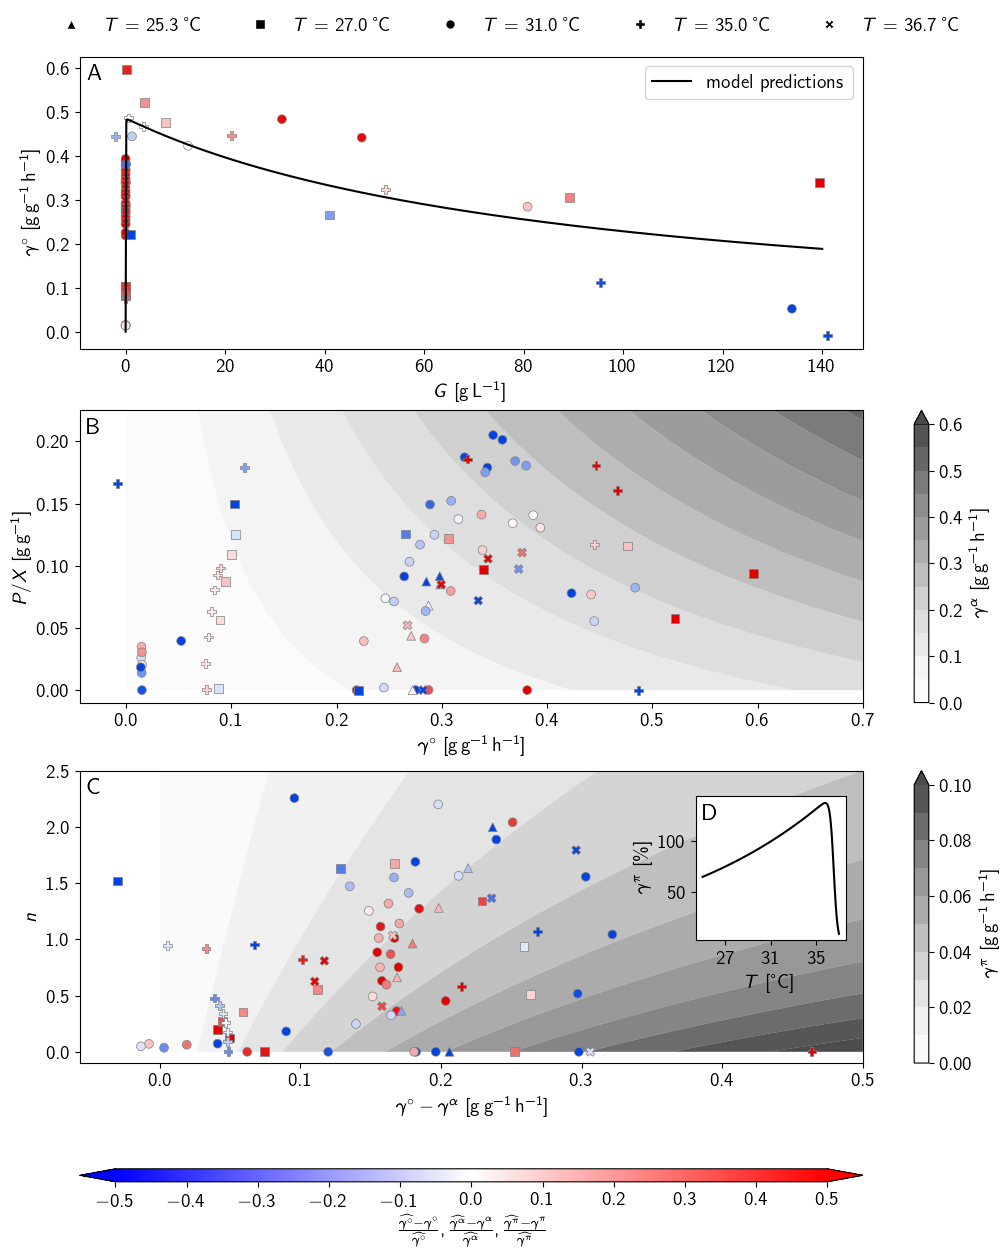

In [95]:
error_range = 0.5
line_color = "k"
markers = ["^", "s", "o", "P", "X"]

fig, (ax_g, ax_gm, ax_gP) = plt.subplots(3, 1, figsize=(10, 12), layout="constrained")
ax_T = fig.add_axes((0.69, 0.26, 0.15, 0.12))

G = np.linspace(0, 140, 1000)
y = f_g(G, np.inf, np.inf, np.inf, 304.15)
ax_g.plot(G, y, c=line_color, label=r"model predictions")

g_est = f_g(
    df_measurement_points.G,
    df_measurement_points.n,
    df_measurement_points.P,
    df_measurement_points.X,
    df_measurement_points["T"],
)


seaborn.scatterplot(
    data=df_measurement_points,
    x="G",
    y="g",
    # hue=(df_measurement_points.g - g_est) / g_est * 100,
    hue=(df_measurement_points.g - g_est) / np.mean(df_measurement_points.g),
    style="target_temperature",
    palette=color_scheme.cmap,
    hue_norm=(-error_range, error_range),
    s=40,
    legend=False,
    edgecolor="grey",
    ax=ax_g,
    markers=markers,
)
ax_g.set_xlabel("$G$ [\si{\gram\per\liter}]")
ax_g.set_ylabel(r"$\g$ [\si{\gram\per\gram\per\hour}]")

ax_g.legend(
    loc="upper right",
    # bbox_to_anchor=(0.1, 1),
)

# qm

gm_est = f_gm(
    df_measurement_points.g,
    df_measurement_points.G,
    df_measurement_points.n,
    df_measurement_points.P,
    df_measurement_points.X,
    df_measurement_points["T"],
)

seaborn.scatterplot(
    data=df_measurement_points,
    x="g",
    y=np.fmax(0, df_measurement_points.P / df_measurement_points.X),
    # hue=(df_measurement_points.gm - gm_est) / gm_est * 100,
    hue=(df_measurement_points.gm - gm_est) / np.mean(df_measurement_points.gm),
    style="target_temperature",
    palette=color_scheme.cmap,
    hue_norm=(-error_range, error_range),
    s=40,
    legend=False,
    edgecolor="grey",
    ax=ax_gm,
    markers=markers,
)
ax_gm.set_xlabel(r"$\g$ [\si{\gram\per\gram\per\hour}]")
ax_gm.set_ylabel(r"$P/X$ [\si{\gram\per\gram}]")

gs = np.linspace(0, 0.7, 100)
PXs = np.linspace(0, 0.225, 100)
gms = np.array([[f_gm(g, 0, 0, P, 1, 304.15) for g in gs] for P in PXs])
gms = np.fmin(gms, gs)

contour_gm = ax_gm.contourf(
    gs,
    PXs,
    gms,
    cmap="Greys",
    levels=np.linspace(0, 0.6, 13),
    extend="max",
    alpha=0.7,
    antialiased=True,
    zorder=-1,
)

cbar_gm = plt.colorbar(contour_gm, ax=ax_gm, extend="min")
cbar_gm.set_label(r"$\gm$ [\si{\gram\per\gram\per\hour}]")
ax_gm.set_ylim(-0.01, None)

# qP

gP_est = f_gP(
    df_measurement_points.g,
    df_measurement_points.gm,
    df_measurement_points.G,
    df_measurement_points.n,
    df_measurement_points.P,
    df_measurement_points.X,
    df_measurement_points["T"],
)

seaborn.scatterplot(
    data=df_measurement_points,
    x="g_gm",
    y="n",
    # hue=(df_measurement_points.gP - gP_est) / gP_est * 100,
    hue=(df_measurement_points.gP - gP_est) / np.mean(df_measurement_points.gP),
    style="target_temperature",
    palette=color_scheme.cmap,
    hue_norm=(-error_range, error_range),
    s=40,
    legend=False,
    edgecolor="grey",
    ax=ax_gP,
    markers=markers,
)
ax_gP.set_xlabel(r"$\g - \gm$ [\si{\gram\per\gram\per\hour}]")
ax_gP.set_ylabel("$n$")

# ax_gP.legend(
#     loc="upper left",
#     bbox_to_anchor=(0.05, 1),
#     title="model predictions",
# )

g_gms = np.linspace(0, 0.5, 100)
ns = np.linspace(0, 2.5, 100)
gPs = np.array([[f_gP(g_gm, 0, 0, n, 0, 1, 304.15) for g_gm in g_gms] for n in ns])


contour_gP = ax_gP.contourf(
    g_gms,
    ns,
    gPs,
    cmap="Greys",
    levels=np.linspace(0, 0.1, 11),
    extend="max",
    alpha=0.7,
    antialiased=True,
    zorder=-1,
)

cbar_gP = plt.colorbar(contour_gP, ax=ax_gP, extend="min")
cbar_gP.set_label(r"$\gP$ [\si{\gram\per\gram\per\hour}]")
ax_gP.set_ylim(-0.1, None)

# add temperature effect in gP axis

Ts = np.linspace(25, 37, 1000) + 273.15
y = f_gP(0.3, 0, 0, 0, 0, 20, Ts)
y = y / f_gP(0.3, 0, 0, 0, 0, 20, 304.15) * 100
ax_T.plot(Ts - 273.15, y, c=line_color)
ax_T.set_xlabel("$T$ [\si{\celsius}]")
ax_T.set_ylabel("$\gP$ [\%]")
ax_T.set_xticks((27, 31, 35))


# color bar

norm = plt.Normalize(-error_range, error_range)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=[ax_g, ax_gm, ax_gP],
    extend="both",
    location="bottom",
    aspect=60,
    fraction=0.04,
)
cbar.set_label(
    r"$\frac{\widehat{\g} - \g}{\widehat{\g}}, \frac{\widehat{\gm} - \gm}{\widehat{\gm}}, \frac{\widehat{\gP} - \gP}{\widehat{\gP}}$"
)
cbar.set_ticks(np.linspace(-error_range, error_range, 11))

label0 = matplotlib.lines.Line2D(
    [],
    [],
    marker=markers[0],
    color="w",
    markerfacecolor="k",
    label="$T$ = \qty{25.3}{\celsius}",
    markersize=7,
)
label1 = matplotlib.lines.Line2D(
    [],
    [],
    marker=markers[1],
    color="w",
    markerfacecolor="k",
    label="$T$ = \qty{27.0}{\celsius}",
    markersize=7,
)
label2 = matplotlib.lines.Line2D(
    [],
    [],
    marker=markers[2],
    color="w",
    markerfacecolor="k",
    label="$T$ = \qty{31.0}{\celsius}",
    markersize=7,
)
label3 = matplotlib.lines.Line2D(
    [],
    [],
    marker=markers[3],
    color="w",
    markerfacecolor="k",
    label="$T$ = \qty{35.0}{\celsius}",
    markersize=7,
)
label4 = matplotlib.lines.Line2D(
    [],
    [],
    marker=markers[4],
    color="w",
    markerfacecolor="k",
    label="$T$ = \qty{36.7}{\celsius}",
    markersize=7,
)
fig.legend(
    handles=[label0, label1, label2, label3, label4],
    loc="lower center",
    bbox_to_anchor=[0.5, 1],
    frameon=False,
    ncol=5,
)

for name, ax in zip(
    ["A", "B", "C", "D", "E", "F", "G", "H"], [ax_g, ax_gm, ax_gP, ax_T]
):
    trans = matplotlib.transforms.ScaledTranslation(
        5 / 72, -5 / 72, fig.dpi_scale_trans
    )
    ax.text(
        0.0,
        1.0,
        name,
        transform=ax.transAxes + trans,
        fontsize="large",
        verticalalignment="top",
        fontfamily="sans",
        bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
    )

fig.get_layout_engine().set(wspace=0.8)

plt.savefig(f"{fig_path}fit_quality.png", bbox_inches="tight")


plt.show()

In [96]:
# calculating the temperature effect on $q_P$ on the target temperatures compared to 31 °C


def temp_factor(T):
    gP_T0 = f_gP(1, 0, 0, 0, 0, 1, 31 + 273.15)
    gP_T = f_gP(1, 0, 0, 0, 0, 1, T + 273.15)
    return (gP_T / gP_T0 - 1) * 100


T_factors = list()
CP = 31
T_var = 4
Ts = [CP - T_var * 2**0.5, CP - T_var, CP, CP + T_var, CP + T_var * 2**0.5]

T_factors = [temp_factor(T) for T in Ts]

pd.DataFrame(
    {
        "T": Ts,
        "T_factor": T_factors,
    }
)

,T,T_factor
0,25.343146,-33.504568
1,27.000000,-24.946552
2,31.000000,0.000000
3,35.000000,32.258869
4,36.656854,-53.363482


### get RSM like results
We set the feed as exponential and the Temperatur constant and calculate the expected product in a grid. Optima are calculated for $P$ and $P/X$. In the manuscript $P/X$ is used as target variable

In [97]:
# feed rate = f0 * exp(mu*t)
# f0 = (g_mu + gm + gP) * X0 / c_f

t_process = 12
grid_n = 1000
Ts = np.linspace(25, 37, grid_n) + 273.15
mus = np.linspace(0, 0.3, grid_n)

x0_mean = np.mean(data_df.X[data_df.t == 0])
x0 = [x0_mean, 0, 0, 1]
c_feed_gL = 390
density_glycerol = 1.261
density = 1 + c_feed_gL / 1000 * (1 - 1 / density_glycerol)
c_feed = c_feed_gL / density


def solve_ode(args):
    mu, T = args
    X0, P0, G0, V0 = x0

    def calc_mu(f0, T):
        g = f0 / (X0 * V0) * c_feed
        gm = f_gm(g, 0, 0, P0, X0, T)
        gP = f_gP(g, gm, 0, 0, P0, X0, T)
        g_mu = g - gP - gm
        mu_est = (g_mu * Y_XG + gP * Y_PG) * (1 - P0 / X0)
        return mu_est - mu

    f_root = np.vectorize(calc_mu)

    sol = scipy.optimize.root_scalar(f=f_root, bracket=[-0.1, 0.2], args=[T])
    f0 = sol.root

    def f(t, x):
        X, P, G, V = x
        u = [f0 * np.exp(mu * t), c_feed, T]
        return f_ode(x, u, x0)

    sol = scipy.integrate.solve_ivp(
        fun=f,
        t_span=(0, t_process),
        y0=x0,
        method="LSODA",
        rtol=1e-12,
    )
    return sol.y[1][-1], sol.y[1][-1] / sol.y[0][-1], sol.y[3][-1], sol.y[0][-1]


with multiprocessing.Pool() as p:
    res = p.map(solve_ode, itertools.product(mus, Ts))

In [98]:
res_P = np.array([x[0] for x in res]).reshape(grid_n, grid_n)
res_PX = np.array([x[1] for x in res]).reshape(grid_n, grid_n)
res_X = np.array([x[3] for x in res]).reshape(grid_n, grid_n)
res_V = np.array([x[2] for x in res]).reshape(grid_n, grid_n)
res_fed_G = (res_V - x0[3]) * c_feed
res_Y_X_app = (res_X * res_V - x0[0]) / res_fed_G
res_Y_P_app = res_P * res_V / res_fed_G

In [99]:
opt_P = scipy.optimize.minimize(
    lambda x: -solve_ode(x)[0], x0=[0.3, 305], tol=1e-6, bounds=[(0, 0.9), (298, 310.5)]
)
opt_P

      fun: -10.230805747001048
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00348894,  0.00084146])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 20
     njev: 36
   status: 0
  success: True
        x: array([1.36425572e-01, 3.08935722e+02])

In [100]:
opt_PX = scipy.optimize.minimize(
    lambda x: -solve_ode(x)[1], x0=[0.3, 305], tol=1e-6, bounds=[(0, 0.9), (298, 310.5)]
)
opt_PX

      fun: -0.18625090316265255
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.22433183e-05, 4.39647969e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 11
     njev: 18
   status: 0
  success: True
        x: array([1.17292509e-01, 3.08935827e+02])

In [101]:
# $\mu_f$ for the training runs is calculated

t = np.linspace(0, 11.5, 25)
mu_feed = dict()
for process in process_names:
    res_fit = scipy.stats.linregress(
        t,
        np.log(
            f_spline[process].f(t)
            * f_spline[process].c_feed(t)
            / f_spline[process].sampling_factor(t)
        ),
    )
    # print(f"{process}: f0 * c_feed = {np.exp(res_fit.intercept)}, mu = {res_fit.slope}")
    mu_feed[process] = res_fit.slope

In [102]:
# calculate estimates and errors for the training data runs

ode = odes[alpha][no_points]

P_est = list()
X_est = list()
T_mean = list()
g_mean = list()
for process in process_names:
    df = data_df[data_df.process == process]

    def feed_rate(t):
        return f_spline[process].f(t) / f_spline[process].sampling_factor(t)

    c_feed = f_spline[process].c_feed
    T = f_spline[process].T

    x0 = [
        df.X.values[0],
        df.P.values[0],
        df.G.values[0],
        df.V.values[0],
    ]

    def f(t, x):
        u = [feed_rate(t), c_feed(t), T(t)]
        return ode.f(x, u, x0)

    sol = scipy.integrate.solve_ivp(
        fun=f, t_span=(0, 12.5), y0=x0, method="LSODA", dense_output=True
    )
    P_est.append(sol.y[1][-1])
    X_est.append(sol.y[0][-1])
    T_mean.append(np.mean(df["T"]))


# p_est[3] = np.mean(p_est[:3])

df_error = pd.DataFrame(
    {
        "process": process_names,
        "P_end": data_df[data_df.t > 11].P,
        "X_end": data_df[data_df.t > 11].X,
    }
)
df_error["P_est"] = P_est
df_error["P_error"] = df_error.P_end - df_error.P_est
df_error["T_mean"] = T_mean
df_error["mu_feed"] = mu_feed.values()
df_error["X_est"] = X_est
df_error["X_error"] = df_error.X_end - df_error.X_est
df_error["PX_est"] = np.array(P_est) / np.array(X_est)
df_error["PX_end"] = df_error.P_end / df_error.X_end
df_error["PX_error"] = df_error.PX_end - df_error.PX_est

In [103]:
df_error

,process,P_end,X_end,P_est,P_error,T_mean,mu_feed,X_est,X_error,PX_est,PX_end,PX_error
6,DoE1_R2,9.41,52.266667,6.920483,2.489517,304.771143,0.114321,47.380132,4.886535,0.146063,0.180038,0.033975
13,DoE1_R4,9.00,49.400000,7.573980,1.426020,304.754143,0.111674,51.415479,-2.015479,0.147309,0.182186,0.034877
20,DoE2_R2,9.87,70.166667,10.874381,-1.004381,305.179286,0.113551,72.258630,-2.091964,0.150492,0.140665,-0.009827
27,DoE2_R4,7.67,58.466667,9.129540,-1.459540,304.185143,0.117839,62.912263,-4.445597,0.145115,0.131186,-0.013930
34,DoE3_R1,0.46,25.733333,0.699856,-0.239856,304.070714,0.005796,24.488844,1.244490,0.028579,0.017876,-0.010703
41,DoE1_R3,5.37,35.950000,2.989273,2.380727,301.489000,0.035687,36.943669,-0.993669,0.080914,0.149374,0.068460
48,DoE2_R3,3.98,40.500000,5.444996,-1.464996,308.116143,0.036192,41.941487,-1.441487,0.129824,0.098272,-0.031552
55,DoE3_R3,5.23,60.150000,5.630169,-0.400169,299.765571,0.115550,55.862577,4.287423,0.100786,0.086949,-0.013837
62,DoE3_R4,3.71,51.166667,2.902724,0.807276,309.799000,0.116348,60.881165,-9.714498,0.047679,0.072508,0.024830
69,DoE3_R2,2.14,47.300000,2.221061,-0.081061,307.762857,0.231576,23.144475,24.155525,0.095965,0.045243,-0.050722


In [104]:
%%R -i df_error
library(rsm)
rsm1 <- rsm(P_end ~ SO(mu_feed, T_mean), data=df_error)
rsm2 <- rsm(PX_end ~ SO(mu_feed, T_mean), data=df_error)
rsm3 <- rsm(X_end ~ SO(mu_feed, T_mean), data=df_error)
# summary(rsm3)

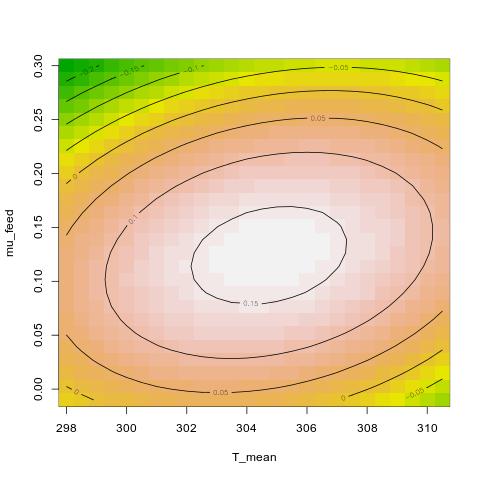

In [105]:
%%R -o x_RSM -o y_RSM -o z_RSM -o opt_RSM -o RSM_predict_P -o opt_RSM_PX -o RSM_predict_PX -o x_RSM_PX -o y_RSM_PX -o z_RSM_PX -o cp_opt_predict -o x_RSM_P -o y_RSM_P -o z_RSM_P
c = contour(rsm1, mu_feed ~ T_mean, image=TRUE, bounds=list(mu_feed = c(-0.01, 0.3), T_mean = c(25 + 273.15, 37 + 273.15)))
x_RSM = c$"T_mean ~ mu_feed"$x
y_RSM = c$"T_mean ~ mu_feed"$y
z_RSM = c$"T_mean ~ mu_feed"$z
opt_RSM = summary(rsm1)$canonical$xs

x_RSM_P = c$"T_mean ~ mu_feed"$x
y_RSM_P = c$"T_mean ~ mu_feed"$y
z_RSM_P = c$"T_mean ~ mu_feed"$z

RSM_predict_P <- predict(rsm1, newdata=df_error)

c = contour(rsm2, mu_feed ~ T_mean, image=TRUE, bounds=list(mu_feed = c(-0.01, 0.3), T_mean = c(298, 310.5)))
x_RSM_PX = c$"T_mean ~ mu_feed"$x
y_RSM_PX = c$"T_mean ~ mu_feed"$y
z_RSM_PX = c$"T_mean ~ mu_feed"$z
opt_RSM_PX = summary(rsm2)$canonical$xs

RSM_predict_PX <- predict(rsm2, newdata=df_error)
df <- data.frame(T_mean = c(304.15, opt_RSM_PX[2]), mu_feed = c(0.11, opt_RSM_PX[1]))
cp_opt_predict = predict(rsm2, newdata=df, interval = "confidence", level=0.95)

In [106]:
df_error["PX_est_RSM"] = RSM_predict_PX
df_error["P_est_RSM"] = RSM_predict_P
df_error["PX_error_RSM"] = df_error.PX_end - df_error.PX_est_RSM
df_error["P_error_RSM"] = df_error.P_end - df_error.P_est_RSM

In [107]:
# improvement compared to the center point (P/X optimized)
(cp_opt_predict[1][0] - cp_opt_predict[0][0]) / cp_opt_predict[0][0]

0.010826295631441777

In [108]:
# cross validation RSM
# leave one out, note that we extrapolate here and no longer use a RSM design in cross-validation
Ps = list()
PXs = list()
Xs = list()
for i, r in enumerate(df_error.iterrows()):
    df = df_error.drop(df_error.index[i], axis=0)
    %R rsm1 <- rsm(P_end ~ SO(mu_feed, T_mean), data=df); -i df
    %R rsm2 <- rsm(PX_end ~ SO(mu_feed, T_mean), data=df); -i df
    %R rsm3 <- rsm(X_end ~ SO(mu_feed, T_mean), data=df); -i df
    p1 = %R predict(rsm1, c(df_error))
    p2 = %R predict(rsm2, c(df_error))
    p3 = %R predict(rsm3, c(df_error))
    Ps.append(p1[i])
    PXs.append(p2[i])
    Xs.append(p3[i])

df_error["P_rsm_CV"] = Ps
df_error["P_rsm_CV_error"] = df_error.P_rsm_CV - df_error.P_end
df_error["PX_rsm_CV"] = PXs
df_error["PX_rsm_CV_error"] = df_error.PX_rsm_CV - df_error.PX_end
df_error["X_rsm_CV"] = Xs
df_error["X_rsm_CV_error"] = df_error.X_rsm_CV - df_error.X_end


In [109]:
Rs = list()

R_squared = 1 - np.sum(df_error.PX_rsm_CV_error**2) / np.sum(
    (df_error.PX_end - df_error.PX_end.mean()) ** 2
)
R_squared_adj = 1 - (1 - R_squared) * (len(df_error) - 1) / (len(df_error) - 6)
Rs.append([R_squared, R_squared_adj])

R_squared = 1 - np.sum(df_error.P_rsm_CV_error**2) / np.sum(
    (df_error.P_end - df_error.P_end.mean()) ** 2
)
R_squared_adj = 1 - (1 - R_squared) * (len(df_error) - 1) / (len(df_error) - 6)
Rs.append([R_squared, R_squared_adj])

R_squared = 1 - np.sum(df_error.X_rsm_CV_error**2) / np.sum(
    (df_error.X_end - df_error.X_end.mean()) ** 2
)
R_squared_adj = 1 - (1 - R_squared) * (len(df_error) - 1) / (len(df_error) - 6)
Rs.append([R_squared, R_squared_adj])

pd.DataFrame(Rs, columns=["R^2_CV", "R^2_adj_CV"], index=["P/X", "P", "X"])

,R^2_CV,R^2_adj_CV
P/X,-1.503434,-3.589629
P,0.457679,0.005745
X,-1.135233,-2.914593


In [110]:
df_error["points"] = [
    "center",
    "center",
    "center",
    "center",
    "star",
    "factorial",
    "factorial",
    "star",
    "star",
    "star",
    "factorial",
    "factorial",
]

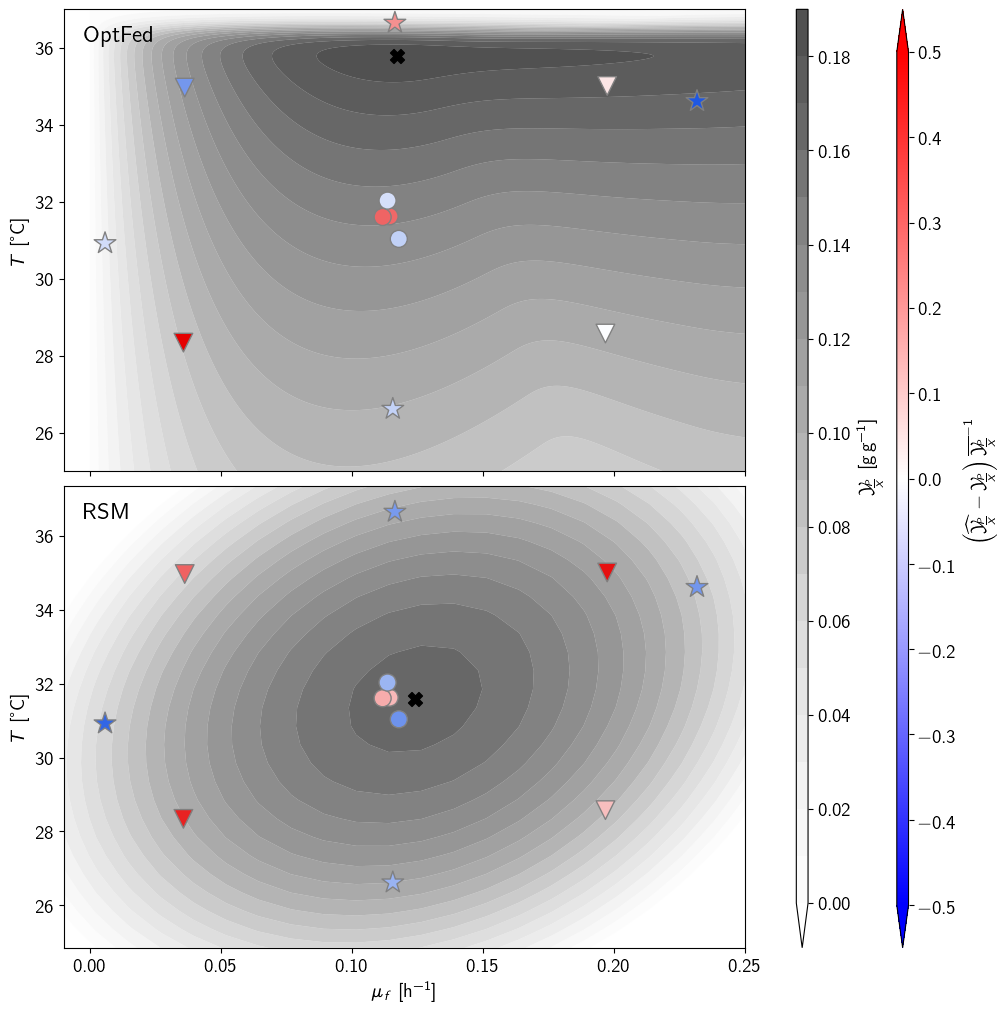

In [111]:
error_col_scale = 0.5

fig, (ax0, ax1) = plt.subplots(
    2, 1, figsize=(10, 10), layout="constrained", sharex=True
)

plot = ax0.contourf(
    mus,
    Ts - 273.15,
    res_PX.T,
    cmap="Greys",
    levels=np.linspace(0, 0.19, 20),
    extend="min",
    alpha=0.7,
    antialiased=True,
)

seaborn.scatterplot(
    data=df_error,
    x="mu_feed",
    y=df_error.T_mean - 273.15,
    hue=df_error.PX_error / np.mean(df_error.PX_end),
    palette=color_scheme.cmap,
    hue_norm=(-error_col_scale, error_col_scale),
    # s=100,
    legend=False,
    edgecolor="gray",
    ax=ax0,
    style="points",
    markers=["o", "*", "v"],
    size="points",
    sizes=[150, 270, 180],
)
ax0.scatter(
    opt_PX.x[0],
    opt_PX.x[1] - 273.15,
    c="k",
    # label="predicted optimum",
    s=100,
    marker="X",
)

plot = ax1.contourf(
    y_RSM_PX,
    x_RSM_PX - 273.15,
    z_RSM_PX,
    cmap="Greys",
    levels=np.linspace(0, 0.19, 20),
    extend="min",
    alpha=0.7,
    antialiased=True,
)


seaborn.scatterplot(
    data=df_error,
    x="mu_feed",
    y=df_error.T_mean - 273.15,
    hue=df_error.PX_error_RSM / np.mean(df_error.P_end / df_error.X_end),
    palette=color_scheme.cmap,
    hue_norm=(-error_col_scale, error_col_scale),
    # s=100,
    legend=False,
    edgecolor="gray",
    ax=ax1,
    style="points",
    markers=["o", "*", "v"],
    size="points",
    sizes=[150, 270, 180],
)

ax1.scatter([opt_RSM_PX[0]], [opt_RSM_PX[1] - 273.15], c="k", s=100, marker="X")

norm = plt.Normalize(-error_col_scale, error_col_scale)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
# ax0.get_legend().remove()


[ax.set_xlabel(r"$\mu_f$ [\si{\per\hour}]") for ax in (ax0, ax1)]
[ax.set_ylabel(r"$T$ [\si{\celsius}]") for ax in (ax0, ax1)]

# fig.legend(loc="lower right")
[ax.set_xlim(-0.01, 0.25) for ax in (ax0, ax1)]
# [ax.set_ylim(25, 37) for ax in (ax0, ax1)]


cbar_error = fig.colorbar(
    sm,
    extend="both",
    ax=[ax0, ax1],
    pad=0.02,
    location="right",
    aspect=80,
    fraction=0.03,
)
cbar_error.set_label(
    r"$\left( \widehat{\PXend} - \PXend \right) \overline{\PXend}^{-1}$"
)
cbar_error.set_ticks(np.linspace(-error_col_scale, error_col_scale, 11))

cbar_value = fig.colorbar(
    plot, location="right", ax=[ax0, ax1], aspect=80, fraction=0.03
)
cbar_value.set_label("$\PXend$ [\si{\gram\per\gram}]")

for name, ax in zip(["\ourmodel", "RSM"], [ax0, ax1]):
    trans = matplotlib.transforms.ScaledTranslation(
        5 / 72, -5 / 72, fig.dpi_scale_trans
    )
    ax.text(
        0.02,
        0.98,
        name,
        transform=ax.transAxes + trans,
        fontsize="large",
        verticalalignment="top",
        fontfamily="sans",
        bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
    )

fig.savefig(f"{fig_path}RSM_model.png")

plt.show()

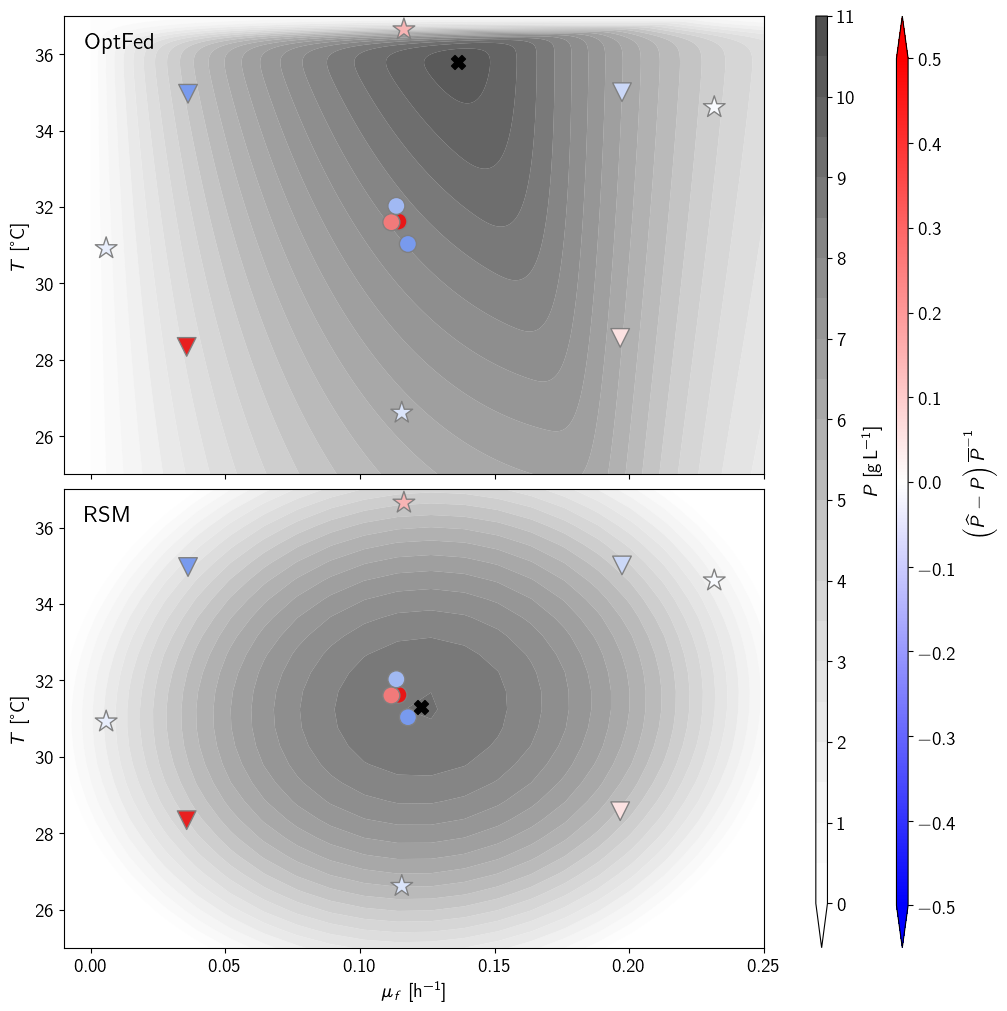

In [112]:
error_col_scale = 0.5

fig, (ax0, ax1) = plt.subplots(
    2, 1, figsize=(10, 10), layout="constrained", sharex=True
)

plot = ax0.contourf(
    mus,
    Ts - 273.15,
    res_P.T,
    cmap="Greys",
    levels=np.linspace(0, 11, 23),
    extend="min",
    alpha=0.7,
    antialiased=True,
)

seaborn.scatterplot(
    data=df_error,
    x="mu_feed",
    y=df_error.T_mean - 273.15,
    hue=df_error.P_error / np.mean(df_error.P_end),
    palette=color_scheme.cmap,
    hue_norm=(-error_col_scale, error_col_scale),
    # s=100,
    legend=False,
    edgecolor="gray",
    ax=ax0,
    style="points",
    markers=["o", "*", "v"],
    size="points",
    sizes=[150, 270, 180],
)
ax0.scatter(
    opt_P.x[0],
    opt_P.x[1] - 273.15,
    c="k",
    # label="predicted optimum",
    s=100,
    marker="X",
)

plot = ax1.contourf(
    y_RSM_P,
    x_RSM_P - 273.15,
    z_RSM_P,
    cmap="Greys",
    levels=np.linspace(0, 11, 23),
    extend="min",
    alpha=0.7,
    antialiased=True,
)


seaborn.scatterplot(
    data=df_error,
    x="mu_feed",
    y=df_error.T_mean - 273.15,
    hue=df_error.P_error / np.mean(df_error.P_end),
    palette=color_scheme.cmap,
    hue_norm=(-error_col_scale, error_col_scale),
    # s=100,
    legend=False,
    edgecolor="gray",
    ax=ax1,
    style="points",
    markers=["o", "*", "v"],
    size="points",
    sizes=[150, 270, 180],
)

ax1.scatter([opt_RSM[0]], [opt_RSM[1] - 273.15], c="k", s=100, marker="X")

norm = plt.Normalize(-error_col_scale, error_col_scale)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
# ax0.get_legend().remove()


[ax.set_xlabel(r"$\mu_f$ [\si{\per\hour}]") for ax in (ax0, ax1)]
[ax.set_ylabel(r"$T$ [\si{\celsius}]") for ax in (ax0, ax1)]

# fig.legend(loc="lower right")
[ax.set_xlim(-0.01, 0.25) for ax in (ax0, ax1)]
# [ax.set_ylim(25, 37) for ax in (ax0, ax1)]


cbar_error = fig.colorbar(
    sm,
    extend="both",
    ax=[ax0, ax1],
    pad=0.02,
    location="right",
    aspect=80,
    fraction=0.03,
)
cbar_error.set_label(
    r"$\left( \widehat{P} - P \right) \overline{P}^{-1}$"
)
cbar_error.set_ticks(np.linspace(-error_col_scale, error_col_scale, 11))

cbar_value = fig.colorbar(
    plot, location="right", ax=[ax0, ax1], aspect=80, fraction=0.03
)
cbar_value.set_label(r"$P$ [\si{\gram\per\liter}]")
cbar_value.set_ticks(np.linspace(0, 11, 12))

for name, ax in zip(["\ourmodel", "RSM"], [ax0, ax1]):
    trans = matplotlib.transforms.ScaledTranslation(
        5 / 72, -5 / 72, fig.dpi_scale_trans
    )
    ax.text(
        0.02,
        0.98,
        name,
        transform=ax.transAxes + trans,
        fontsize="large",
        verticalalignment="top",
        fontfamily="sans",
        bbox=dict(facecolor="none", edgecolor="none", pad=3.0),
    )

plt.show()

# appearent yiels

Appearant yields are calculated for the whole production phase. They include maintenance and therefore are lower than Y_XG and Y_PG.

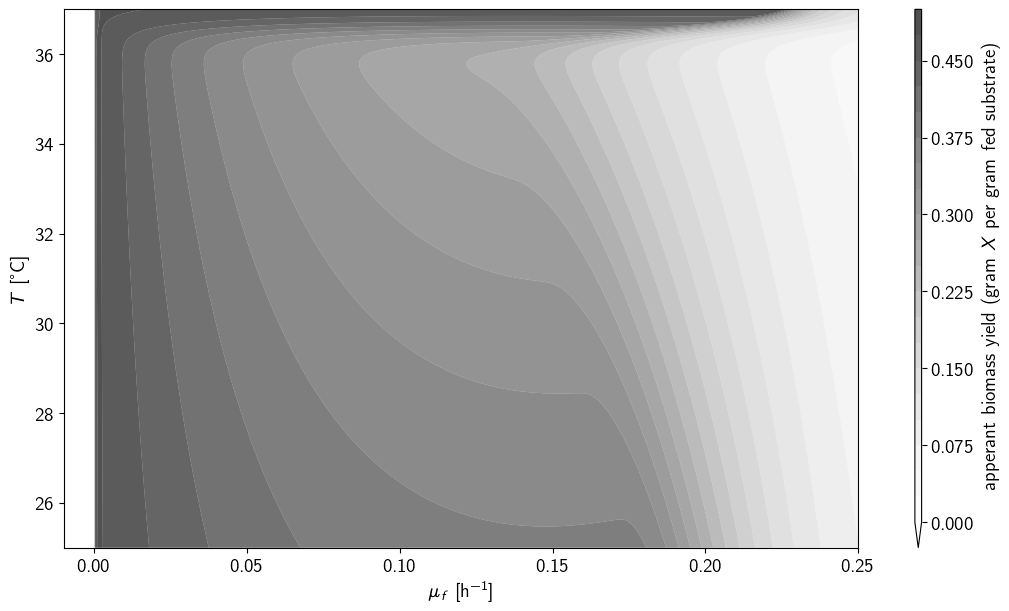

In [113]:
fig, ax0 = plt.subplots(
    1, 1, figsize=(10, 6), layout="constrained", sharex=True
)

plot = ax0.contourf(
    mus,
    Ts - 273.15,
    res_Y_X_app.T,
    cmap="Greys",
    levels=np.linspace(0, 0.5, 21),
    extend="min",
    alpha=0.7,
    antialiased=True,
)

norm = plt.Normalize(-error_col_scale, error_col_scale)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
sm.set_array([])


ax0.set_xlabel(r"$\mu_f$ [\si{\per\hour}]")
ax0.set_ylabel(r"$T$ [\si{\celsius}]")

ax0.set_xlim(-0.01, 0.25)

cbar_value = fig.colorbar(
    plot, location="right", ax=[ax0], aspect=80, fraction=0.03
)
cbar_value.set_label("apperant biomass yield (gram $X$ per gram fed substrate)")

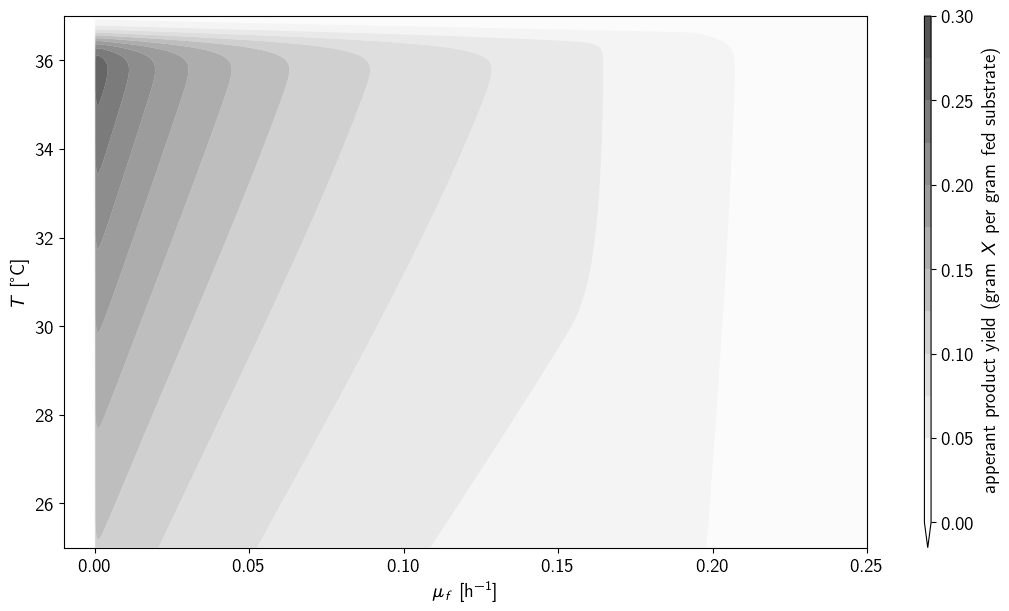

In [114]:
fig, ax0 = plt.subplots(
    1, 1, figsize=(10, 6), layout="constrained", sharex=True
)

plot = ax0.contourf(
    mus,
    Ts - 273.15,
    res_Y_P_app.T,
    cmap="Greys",
    levels=np.linspace(0, 0.3, 13),
    extend="min",
    alpha=0.7,
    antialiased=True,
)

norm = plt.Normalize(-error_col_scale, error_col_scale)
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
sm.set_array([])


ax0.set_xlabel(r"$\mu_f$ [\si{\per\hour}]")
ax0.set_ylabel(r"$T$ [\si{\celsius}]")

ax0.set_xlim(-0.01, 0.25)

cbar_value = fig.colorbar(
    plot, location="right", ax=[ax0], aspect=80, fraction=0.03
)
cbar_value.set_label("apperant product yield (gram $X$ per gram fed substrate)")

In [115]:
# calculate flux destribution bettween growth, production and maintanance
# this is later used in the validation notebook

c_f = 390

def solve_rates(mu, T):
    T = T + 273.15
    x0 = [30, 0, 0, 1]
    X0, P0, G0, V0 = x0

    def calc_mu(f0, T):
        g = f0 / (X0 * V0) * c_f
        gm = f_gm(g, 0, 0, P0, X0, T)
        gP = f_gP(g, gm, 0, 0, P0, X0, T)
        g_mu = g - gP - gm
        mu_est = (g_mu * Y_XG + gP * Y_PG) * (1 - P0 / X0)
        return mu_est - mu

    f_root = np.vectorize(calc_mu)

    sol = scipy.optimize.root_scalar(f=f_root, bracket=[-0.1, 0.2], args=[T])
    f0 = sol.root

    def f(t, x):
        X, P, G, V = x
        u = [f0 * np.exp(mu * t), c_f, T]
        return f_ode(x, u, x0)

    sol = scipy.integrate.solve_ivp(
        fun=f,
        t_span=(0, t_process),
        y0=x0,
        method="LSODA",
        rtol=1e-12,
        t_eval=np.linspace(0, t_process, 121),
    )
    df = pd.DataFrame(sol.y.T, columns=["X", "P", "G", "V"], index=sol.t)
    df["n"] = np.log2(df.X * df.V / (X0 * V0))
    df["g"] = [ode.f_g(G, n, P, X, T) for G, n, P, X in zip(df.G, df.n, df.P, df.X)]
    df["gm"] = [ode.f_gm(g, G, n, P, X, T) for g, G, n, P, X in zip(df.g, df.G, df.n, df.P, df.X)]
    df["gP"] = [ode.f_gP(g, gm, G, n, P, X, T) for g, gm, G, n, P, X in zip(df.g, df.gm, df.G, df.n, df.P, df.X)]
    df["g_mu"] = df.g - df.gP - df.gm
    df["rel_gP"] = df.gP / df.g
    df["rel_g_mu"] = df.g_mu / df.g
    df["rel_gm"] = df.gm / df.g
    return df

df_31 = solve_rates(0.11, 31)
df_opt = solve_rates(0.11, 35.8)


In [116]:
with open(f"{data_dir}ref_rates.pickle", "wb") as f:
    pickle.dump(df_opt, f)